# Food Delivery Time Prediction - Analysis

Given the number of methods and models, the code may take a few minutes to execute.  
If you want to view the results without running it, go to the file _Food_delivery_analisis.html_.


---

# Setup

As a first step, we import the necessary libraries and tools.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2_contingency
from scipy.stats import boxcox

from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)

from functools import partial
from sklearn.model_selection import (cross_validate, KFold, ShuffleSplit, train_test_split, cross_val_score, GridSearchCV)
from sklearn.base import clone
from ISLP.models import sklearn_sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_absolute_error, r2_score

from IPython.display import HTML


The dataset _Food Delivery Times_ is imported from the Git directory.  
After examining the contents of the database, we observe the presence of null values. It has been decided to remove these rows.  
Null values are removed because they can interfere with the calculations of the model, leading to inaccurate results.

In [2]:
Food = pd.read_csv("dataset/Food_Delivery_Times.csv")
print("Number of rows in the original dataset:", len(Food))

null_rows = Food.isnull().any(axis=1).sum()
print("Number of rows with missing values:", null_rows)

Food = Food.dropna()
print("Number of rows after removing missing values:", len(Food))

Food.head()


Number of rows in the original dataset: 1000
Number of rows with missing values: 117
Number of rows after removing missing values: 883


Order_ID  Distance_km Weather Traffic_Level Time_of_Day Vehicle_Type  \
0       522         7.93   Windy           Low   Afternoon      Scooter   
1       738        16.42   Clear        Medium     Evening         Bike   
2       741         9.52   Foggy           Low       Night      Scooter   
3       661         7.44   Rainy        Medium   Afternoon      Scooter   
4       412        19.03   Clear           Low     Morning         Bike   

   Preparation_Time_min  Courier_Experience_yrs  Delivery_Time_min  
0                    12                     1.0                 43  
1                    20                     2.0                 84  
2                    28                     1.0                 59  
3                     5                     1.0                 37  
4                    16                     5.0                 68

In [3]:
variables = {
    'Order_ID': 'Order ID',
    'Distance_km': 'Distance (km)',
    'Weather': 'Weather',
    'Traffic_Level': 'Traffic Level',
    'Time_of_Day': 'Time of Day',
    'Vehicle_Type': 'Vehicle Type',
    'Preparation_Time_min': 'Preparation Time (min)',
    'Courier_Experience_yrs': 'Courier Experience (yrs)',
    'Delivery_Time_min': 'Delivery Time (min)',
    'Courier_Experience': 'Courier Experience'
}

Outliers are extreme values that can distort analysis and lead to misleading results.  
We used the Interquartile Range (IQR) method to detect and remove them.  
This ensures cleaner data and more reliable outcomes in the following analyses.


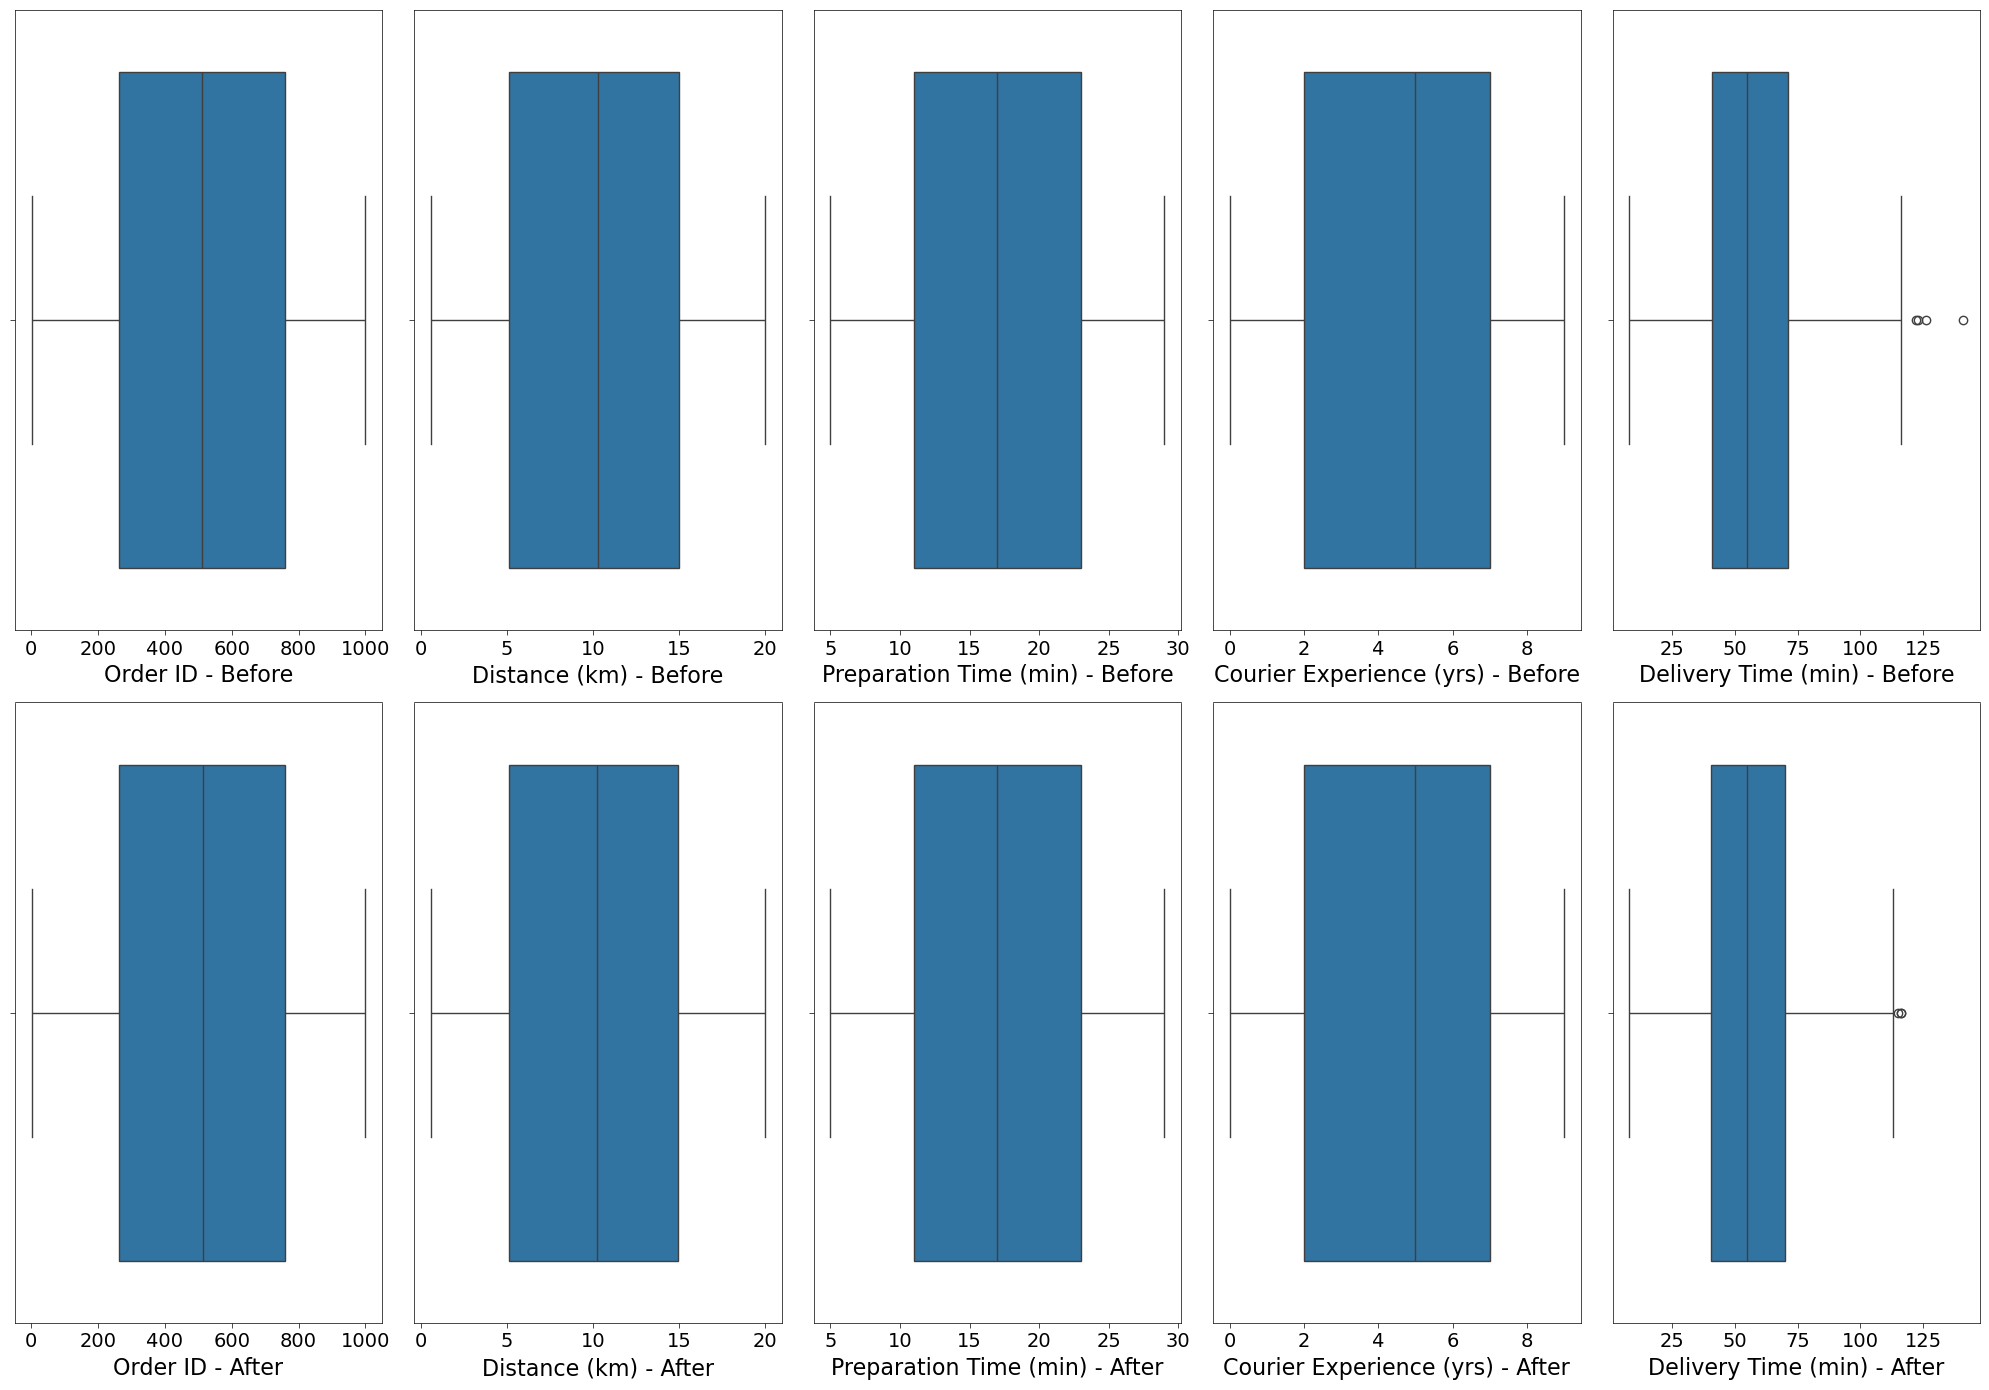

Number of rows after removing outliers 879


In [4]:
Food_original = Food.copy()
xlims = []

plt.figure(figsize=(20, 14))
font_size = 16
tick_size = 14

numeric_columns = Food.select_dtypes(include=['number']).columns.tolist()

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, len(numeric_columns), i)
    ax = sns.boxplot(x=Food_original[col])
    plt.xlabel(f"{variables.get(col, col)} - Before", fontsize=font_size)
    plt.tick_params(axis='both', labelsize=tick_size, color='black', width=0.5)
    xlims.append(ax.get_xlim())

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in numeric_columns:
    Food = remove_outliers(Food, col)

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, len(numeric_columns), len(numeric_columns) + i)
    ax = sns.boxplot(x=Food[col])
    plt.xlim(xlims[i-1])
    plt.xlabel(f"{variables.get(col, col)} - After", fontsize=font_size)
    plt.tick_params(axis='both', labelsize=tick_size, color='black', width=0.5)

for ax in plt.gcf().get_axes():
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(0.5)

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.4, hspace=0.4)
plt.tight_layout()
plt.show()

print("Number of rows after removing outliers", len(Food))


The boxplots show the distribution of numerical variables before and after outlier removal.  
The dataset shows good quality as it contains few outliers.  
The cleaned data is now more consistent and less influenced by rare or abnormal values.

We now present the distribution of each variable to understand how frequently different values occur, both for numerical features and categorical features

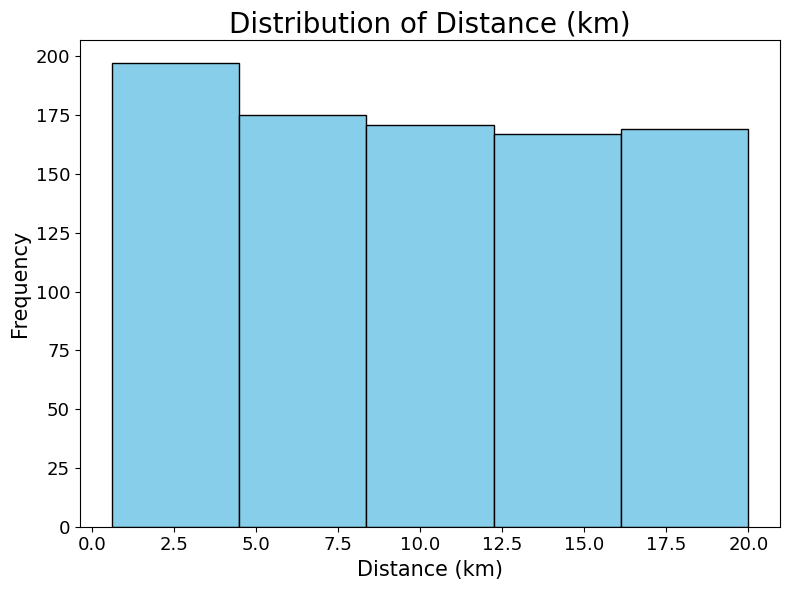

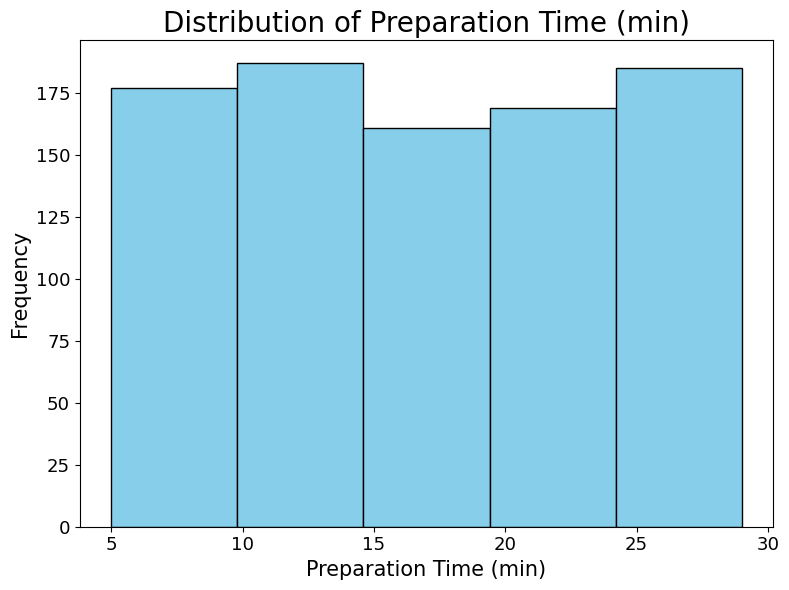

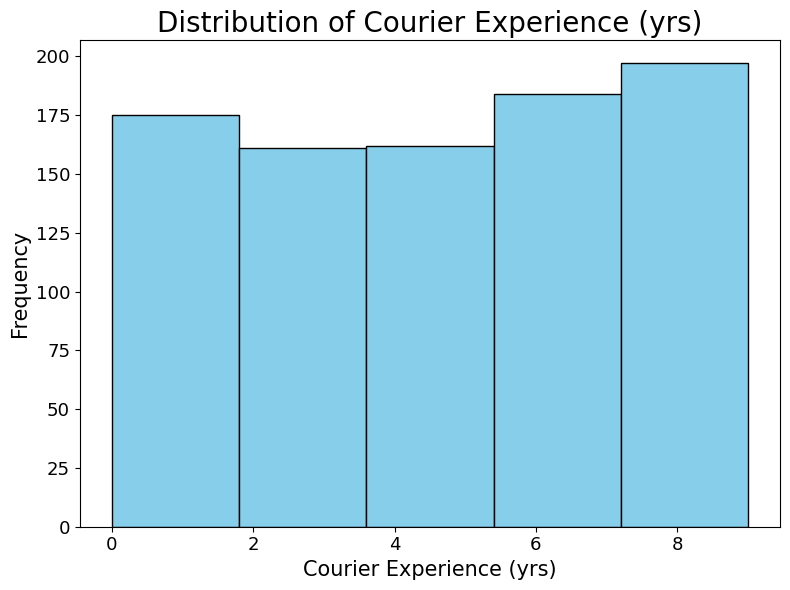

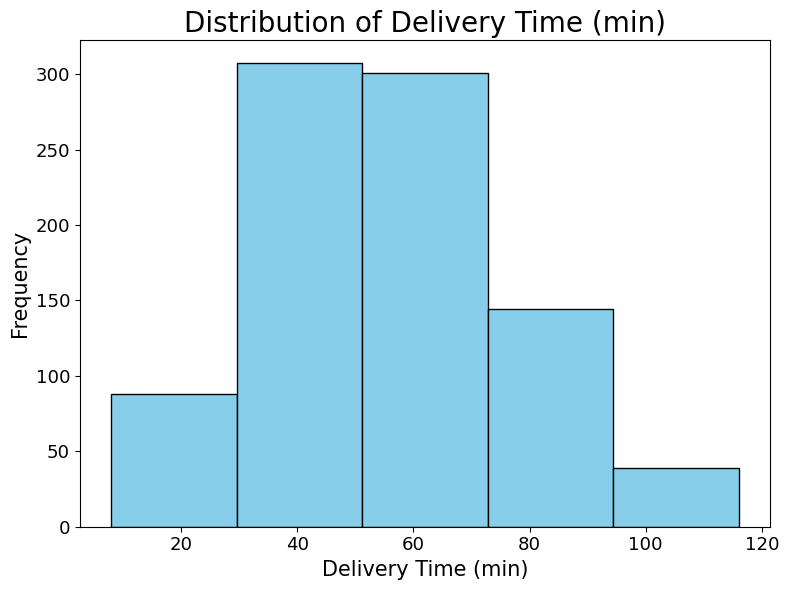

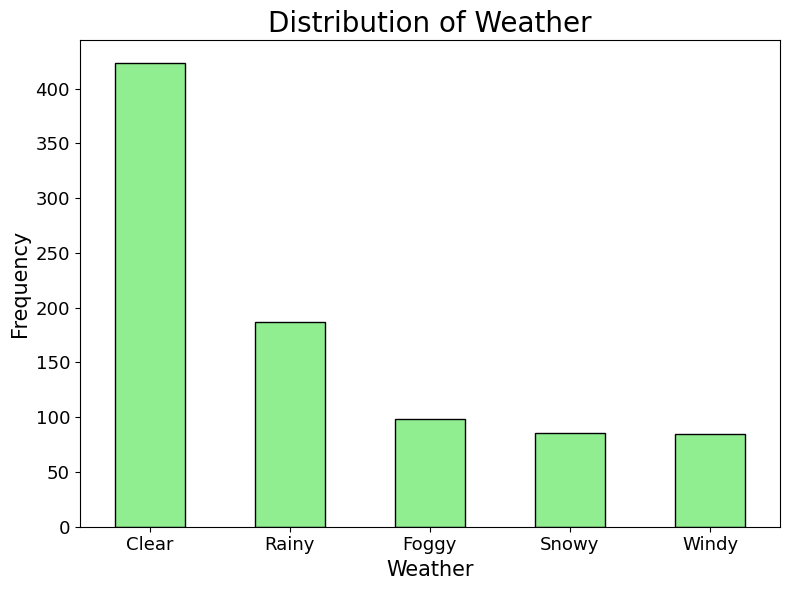

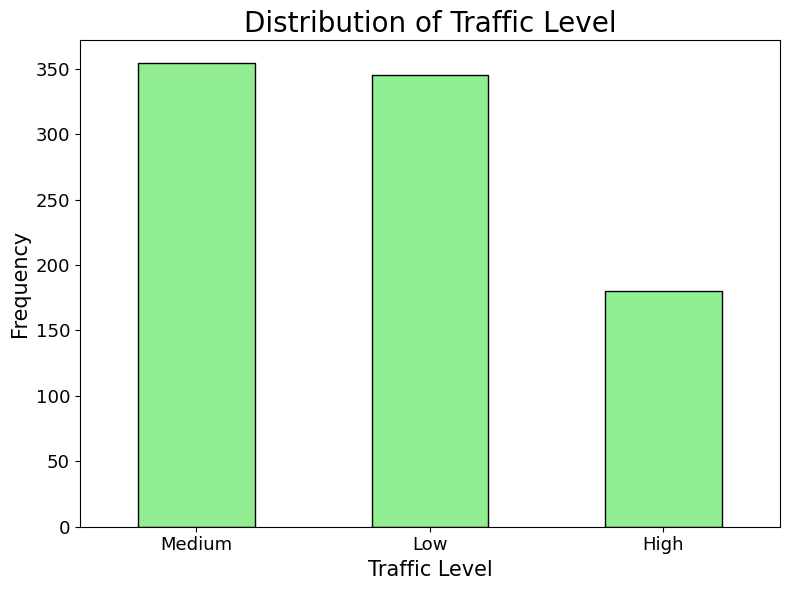

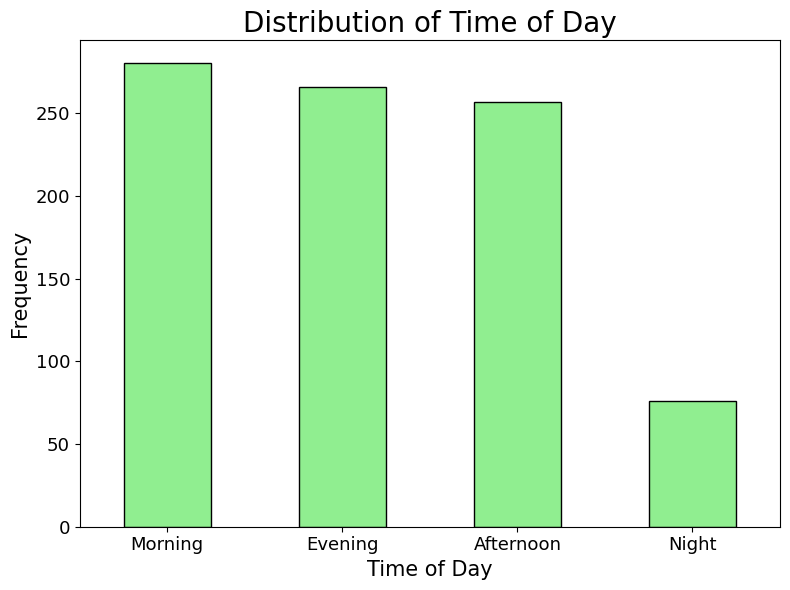

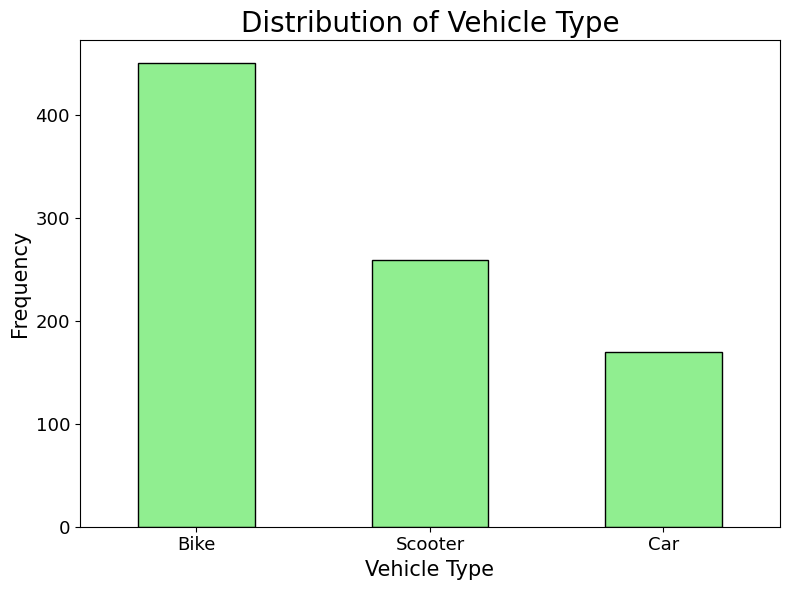

In [5]:
title_fontsize = 20
label_fontsize = 15
tick_fontsize = 13

numerical_cols = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs', 'Delivery_Time_min']

for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    plt.hist(Food[col], bins=5, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {variables[col]}', fontsize=title_fontsize)
    plt.xlabel(variables[col], fontsize=label_fontsize)
    plt.ylabel('Frequency', fontsize=label_fontsize)
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    plt.tight_layout()
    plt.show()

categorical_cols = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']

for col in categorical_cols:
    plt.figure(figsize=(8, 6))
    Food[col].value_counts().plot(kind='bar', color='lightgreen', edgecolor='black')
    plt.title(f'Distribution of {variables[col]}', fontsize=title_fontsize)
    plt.xlabel(variables[col], fontsize=label_fontsize)
    plt.ylabel('Frequency', fontsize=label_fontsize)
    plt.xticks(fontsize=tick_fontsize, rotation=0)
    plt.yticks(fontsize=tick_fontsize)
    plt.tight_layout()
    plt.show()

---

# Simple Linear Regression

Before building regression models, we assess the quality of the dataset by analyzing the correlation between variables through the construction of a correlation matrix.  

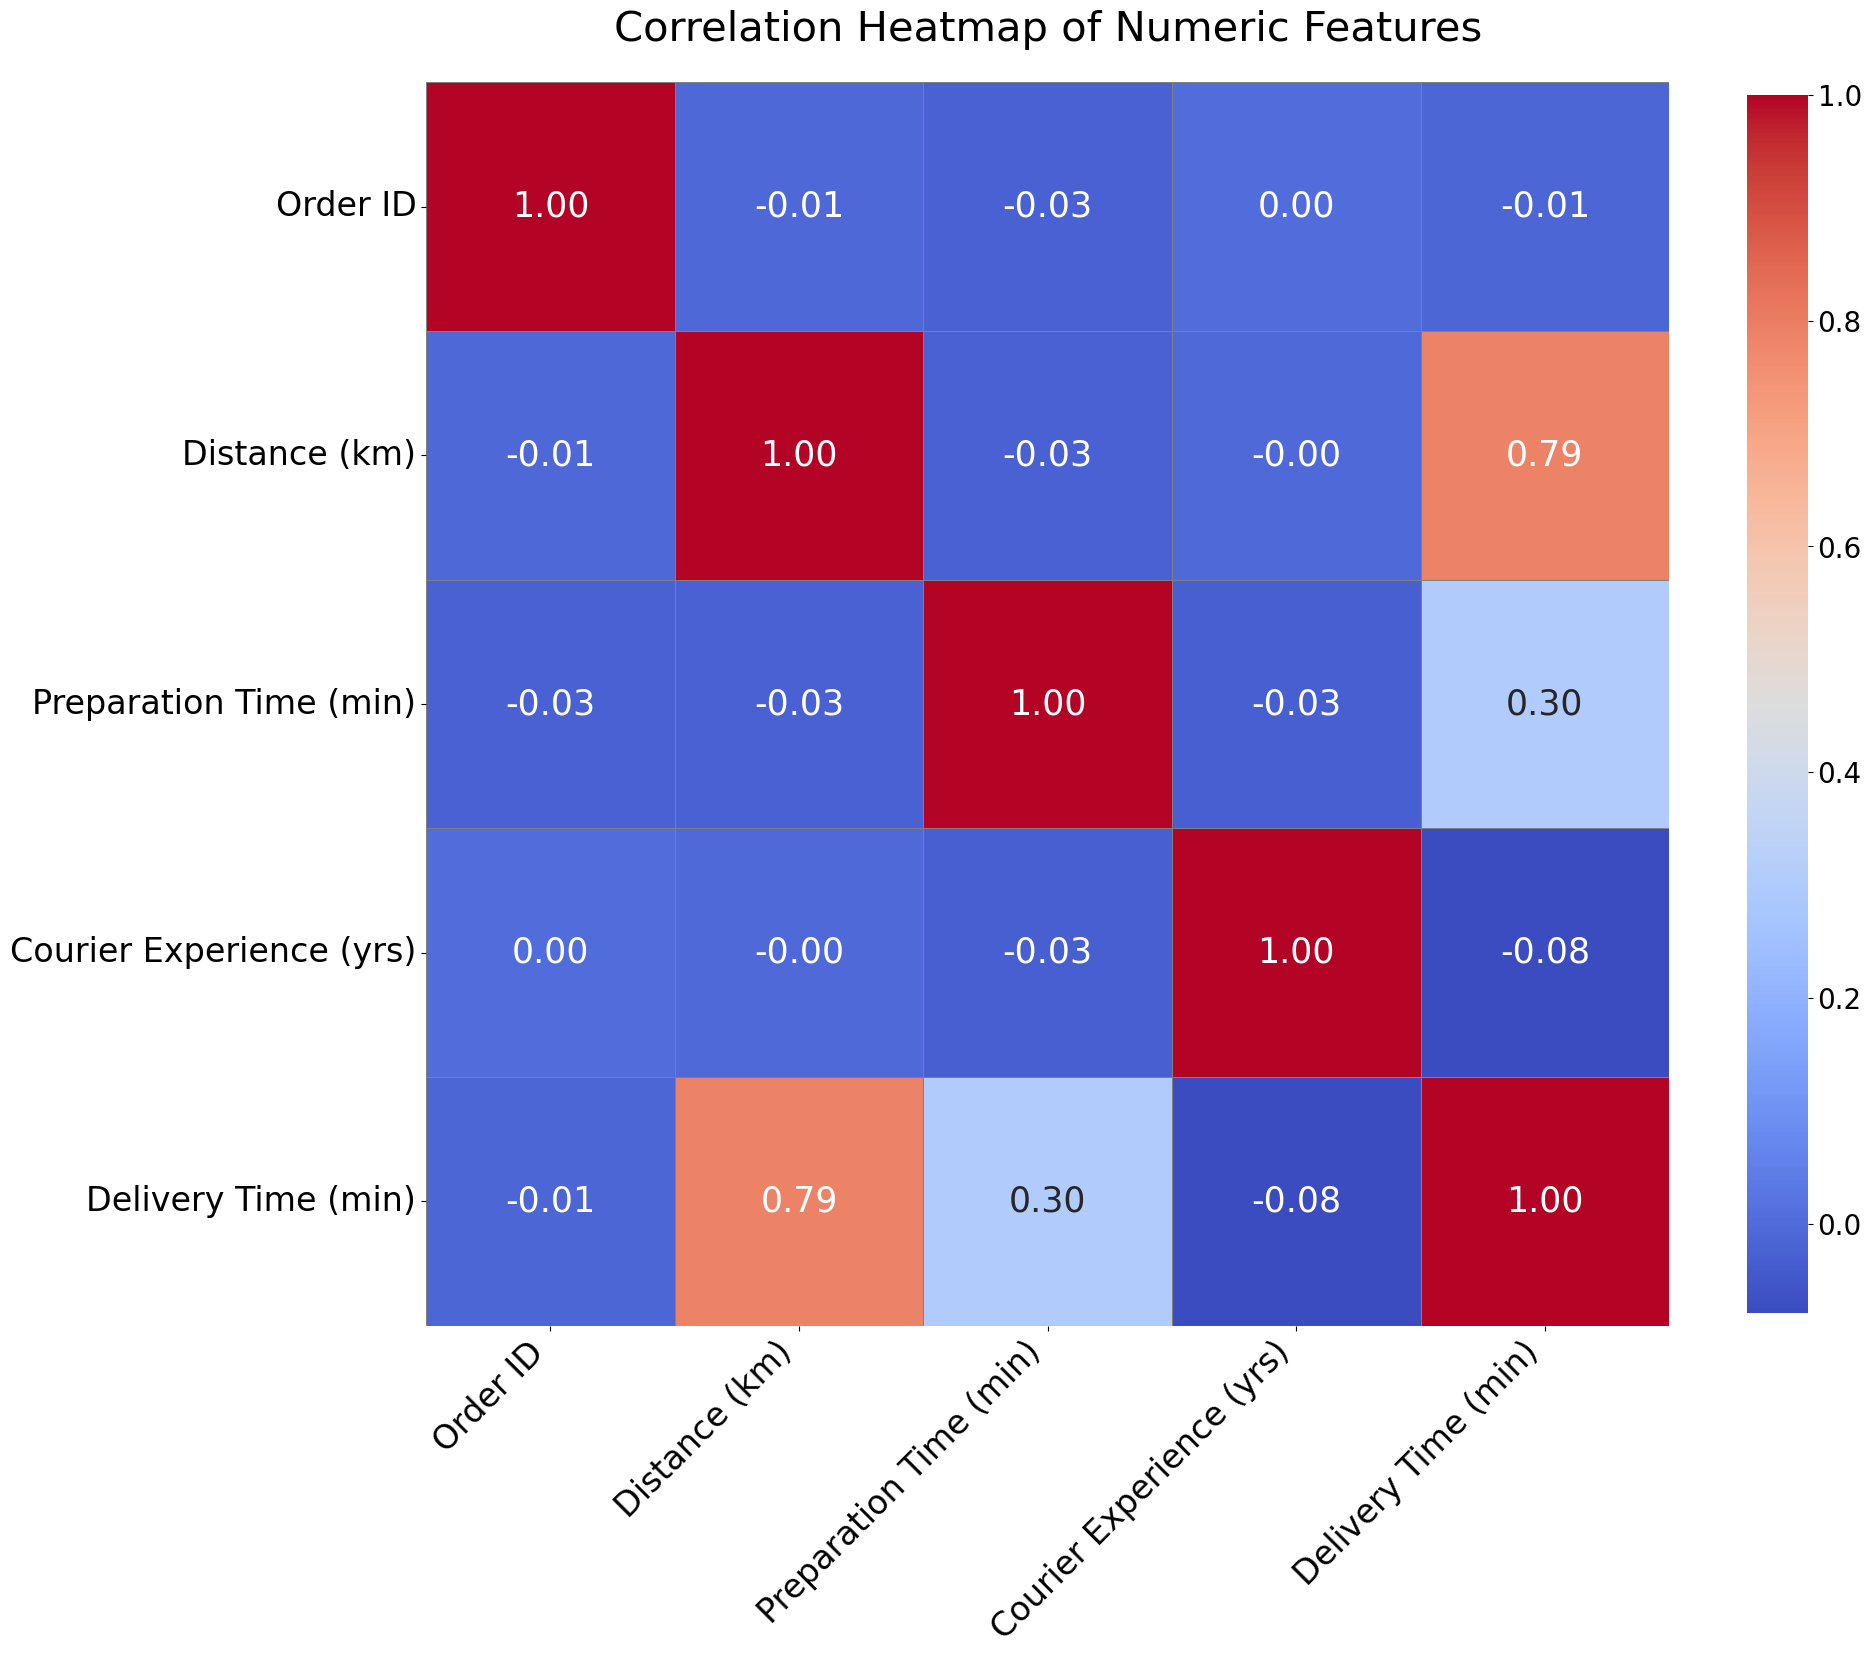

In [6]:
numeric_df = Food.select_dtypes(include=[np.number])

if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(20, 18))
    corr = numeric_df.corr()
    corr.index = [variables.get(col, col) for col in corr.index]
    corr.columns = [variables.get(col, col) for col in corr.columns]
    ax = sns.heatmap(
        corr,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        annot_kws={"size": 25},
        cbar_kws={"shrink": 0.8},
        linewidths=0.7,
        square=True,
        linecolor='gray'
    )
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=24, rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=24, rotation=0)
    ax.set_title("Correlation Heatmap of Numeric Features", fontsize=30, pad=30)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    plt.tight_layout()
    plt.show()


In our case, some variables show a clear linear relationship with delivery time, indicating their potential importance in the regression model.  
Additionally, the predictors are not highly correlated with each other, suggesting that the dataset is suitable for linear regression and that multicollinearity is not a concern.


The two numerical variables _Distance (km)_ and _Preparation Time (min)_ are selected, and the relationship between each of them and the response variable _Delivery Time (min)_ is analyzed individually.  
The variable _Order ID_ is completely irrelevant to our objective, so we do not take it into account.  
_Courier Experience (yrs)_ is numeric from 0 to 9, but we will consider it as categorical  because the values represent discrete levels of experience and their relationship with the target variable may not be linear.


-  ## First case: 
#### _Delivery Time (min)_ = _b0_ + _b1_ * _Distance (km)_ + _e_

In [7]:
X = pd.DataFrame({
    'intercept': np.ones(Food.shape[0]),
    variables['Distance_km']: Food['Distance_km']
})
X[:4]


intercept  Distance (km)
0        1.0           7.93
1        1.0          16.42
2        1.0           9.52
3        1.0           7.44

In [8]:
def summarize(results):
    table = results.summary2().tables[1]

    table = table.drop(columns=['[0.025', '0.975]'], errors='ignore')

    rows = []
    for idx, row in table.iterrows():
        coef = row['Coef.']
        pval = row['P>|t|']
        opacity = "opacity: 0.35;" if pval >= 0.05 else ""

        coef_color = 'green' if coef >= 0 else 'red'
        coef_html = f'<td style="color: {coef_color}; font-weight: bold;">{coef:.3f}</td>'
        pval_html = f'<td style="font-weight: bold;">{pval:.3f}</td>'

        html_row = (
            f'<tr style="{opacity}">'
            f'<th style="font-weight: bold;">{idx}</th>{coef_html}'
            f'<td>{row["Std.Err."]:.3f}</td>'
            f'<td>{row["t"]:.3f}</td>{pval_html}</tr>'
        )
        rows.append(html_row)

    header = (
        "<tr><th></th><th>Coef.</th><th>Std.Err.</th><th>t</th><th>P>|t|</th></tr>"
    )
    html_table = (
        f"<table border='1' class='dataframe'>"
        f"<thead>{header}</thead><tbody>{''.join(rows)}</tbody></table>"
    )

    return HTML(html_table)


In [12]:
y = Food['Delivery_Time_min']
model = sm.OLS(y, X) 
results = model.fit() 
summarize(results)

Distance has a p-value of 0.000, indicating that it is highly significant.  
The coefficient is positive, meaning that as the distance increases, the waiting time also increases.  
The intercept is high, suggesting that distance alone does not sufficiently explain the delivery times.  

### Model prediction and confidence intervals

We define a linear regression design matrix including an intercept and the explanatory variable _Distance (km)_ using the ModelSpec class from ISLP.  
This allows for consistent and automatic construction of the design matrix for both the original dataset and new observations.  

We then generate predictions and 95% confidence intervals for new values of the distance based on the previously fitted model.


In [13]:
model = MS(['Distance_km'])
model = model.fit(Food) 
X = model.transform(Food)
X.columns = [variables.get(col, col) for col in X.columns]
X[:4]

intercept  Distance (km)
0        1.0           7.93
1        1.0          16.42
2        1.0           9.52
3        1.0           7.44

In [14]:
new_df = pd.DataFrame({'Distance_km':[10, 12, 14, 16, 20]})
newX = model.transform(new_df) 
newX.columns = [variables.get(col, col) for col in X.columns]
newX

intercept  Distance (km)
0        1.0             10
1        1.0             12
2        1.0             14
3        1.0             16
4        1.0             20

In [15]:
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean

array([56.047364  , 61.88336722, 67.71937045, 73.55537368, 85.22738013])

In [16]:
new_predictions.conf_int(alpha=0.05)

array([[55.18622211, 56.90850588],
       [60.97123424, 62.79550021],
       [66.66742956, 68.77131134],
       [72.30423639, 74.80651096],
       [83.48514315, 86.96961711]])

These intervals suggest that the model provides reasonably tight estimates for the predicted waiting times, with relatively small ranges around each predicted value.  
This indicates a good level of precision in the model's predictions.


### Graphs

1. #### Regression line

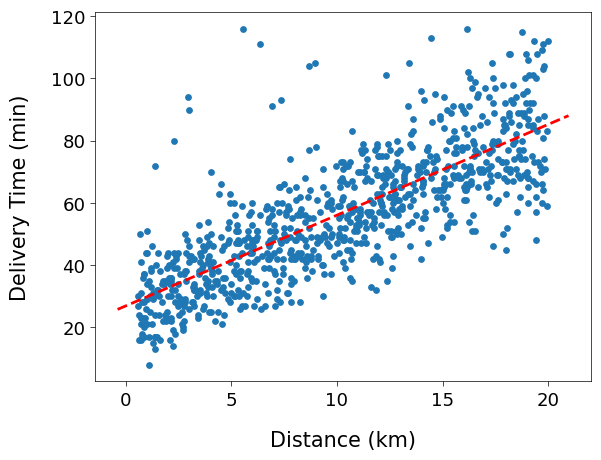

In [17]:
def abline(ax, b, m, *args, **kwargs):
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

ax = Food.plot.scatter('Distance_km', 'Delivery_Time_min', s=15)  
abline(ax, results.params.iloc[0], results.params.iloc[1], 'r--', linewidth=2)

ax.set_xlabel(variables.get('Distance_km', 'Distance_km'), labelpad=15, fontsize=15) 
ax.set_ylabel(variables.get('Delivery_Time_min', 'Delivery_Time_min'), labelpad=15, fontsize=15)

ax.tick_params(axis='both', which='both', color='black', width=0.5, labelsize=13)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.5)

ax.get_figure().canvas.draw()


The scatter plot shows a positive correlation between distance in kilometers and delivery time in minutes.  
The data points align well with the linear trend line, indicating that the model is accurate and useful for predicting delivery times based on distance.

2. #### Fitted values vs residuals

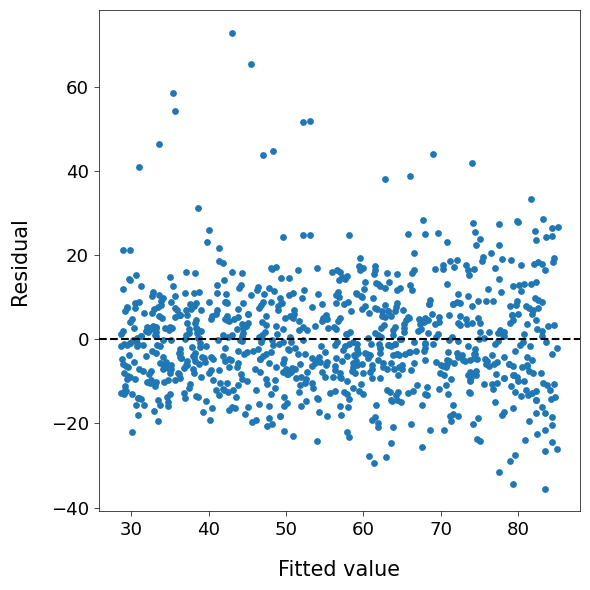

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(results.fittedvalues, results.resid, s=15)
ax.set_xlabel('Fitted value', fontsize=15, labelpad=15)
ax.set_ylabel('Residual', fontsize=15, labelpad=15)
ax.axhline(0, c='k', ls='--')

ax.tick_params(axis='both', which='both', color='black', width=0.5, labelsize=13)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.5)

fig.tight_layout()


The residuals are spread around the zero line, indicating that the model fits the data well.  
There are no clear patterns in the residuals, suggesting the model's assumptions about linearity are valid.

3. #### Leverage

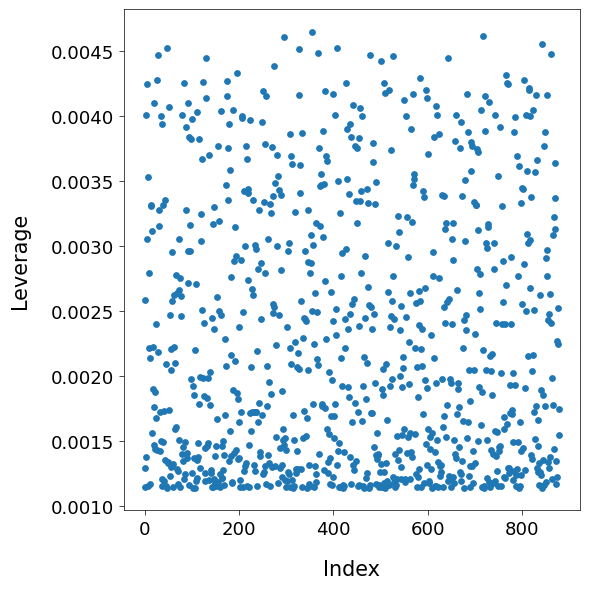

In [19]:
infl = results.get_influence()
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag, s=15)
ax.set_xlabel('Index', fontsize=15, labelpad=15)
ax.set_ylabel('Leverage', fontsize=15, labelpad=15)

ax.tick_params(axis='both', which='both', color='black', width=0.5, labelsize=13)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.5)

fig.tight_layout()

_ = np.argmax(infl.hat_matrix_diag)


The leverage values are low, meaning no single data point has too much impact on the model.  
The leverage level for outliers is 0.0045. Since almost all data points are below this threshold, the model is well-balanced.


-  ## Second case: 
#### _Delivery Time (min)_ = _b0_ + _b1_ * _Preparation Time (min)_ + _e_

In [20]:
X = pd.DataFrame({
    'intercept': np.ones(Food.shape[0]),
    variables['Preparation_Time_min']: Food['Preparation_Time_min']
})
X[:4]

intercept  Preparation Time (min)
0        1.0                      12
1        1.0                      20
2        1.0                      28
3        1.0                       5

In [21]:
y = Food['Delivery_Time_min']
model = sm.OLS(y, X) 
results = model.fit() 
summarize(results)

_Preparation Time (min)_ has a p-value of 0.000, indicating that it is highly significant.  
The coefficient is positive, meaning that as the preparation time increases, the waiting time also increases.  
The intercept is relatively high, suggesting that preparation time alone does not fully explain the total waiting time.  

### Model prediction and confidence intervals

In [22]:
model = MS(['Preparation_Time_min'])
model = model.fit(Food) 
X = model.transform(Food)
X.columns = [variables.get(col, col) for col in X.columns]
X[:4]


intercept  Preparation Time (min)
0        1.0                      12
1        1.0                      20
2        1.0                      28
3        1.0                       5

In [23]:
new_df = pd.DataFrame({'Preparation_Time_min':[10, 12, 14, 16, 20]})
newX = model.transform(new_df)
newX.columns = [variables.get(col, col) for col in X.columns]
newX

intercept  Preparation Time (min)
0        1.0                      10
1        1.0                      12
2        1.0                      14
3        1.0                      16
4        1.0                      20

In [24]:
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean

array([49.99800226, 51.73863378, 53.47926529, 55.21989681, 58.70115983])

In [25]:
new_predictions.conf_int(alpha=0.05)

array([[48.14830241, 51.84770211],
       [50.12183792, 53.35542964],
       [52.03868239, 54.91984819],
       [53.87634173, 56.56345188],
       [57.26216877, 60.1401509 ]])

These intervals indicate that the model produces slightly less accurate predictions for the waiting times than the previous model, with larger ranges surrounding each predicted value.  
This suggests that the model has a good degree of precision in its estimates.



### Graphs

1. #### Regression line

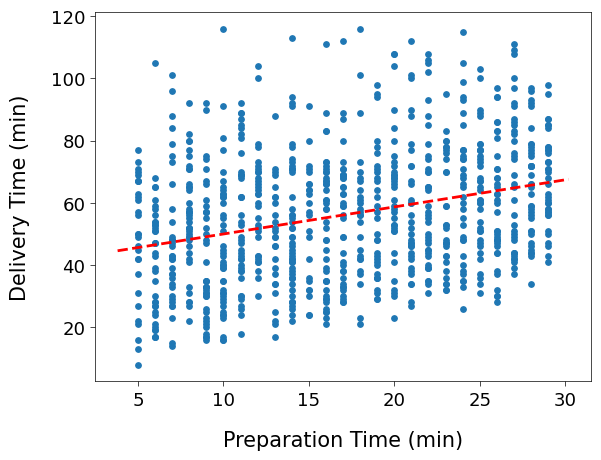

In [26]:
def abline(ax, b, m, *args, **kwargs):
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

ax = Food.plot.scatter('Preparation_Time_min', 'Delivery_Time_min', s=15)  
abline(ax, results.params.iloc[0], results.params.iloc[1], 'r--', linewidth=2)

ax.set_xlabel(variables.get('Preparation_Time_min', 'Preparation_Time_min'), fontsize=15, labelpad=15) 
ax.set_ylabel(variables.get('Delivery_Time_min', 'Delivery_Time_min'), fontsize=15, labelpad=15)

ax.tick_params(axis='both', which='both', color='black', width=0.5, labelsize=13)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.5)

ax.get_figure().canvas.draw()


The scatter plot shows a positive correlation between preparation time and delivery time in minutes.  
The data points generally align with the linear trend line, suggesting that the model is reasonably good.  
However, compared to the previous model, the dispersion of the data points appears to increase.  
Additionally, there is noticeable vertical overlap between points at similar time values, indicating that other factors beyond distance may also influence delivery times.


2. #### Fitted values vs residuals

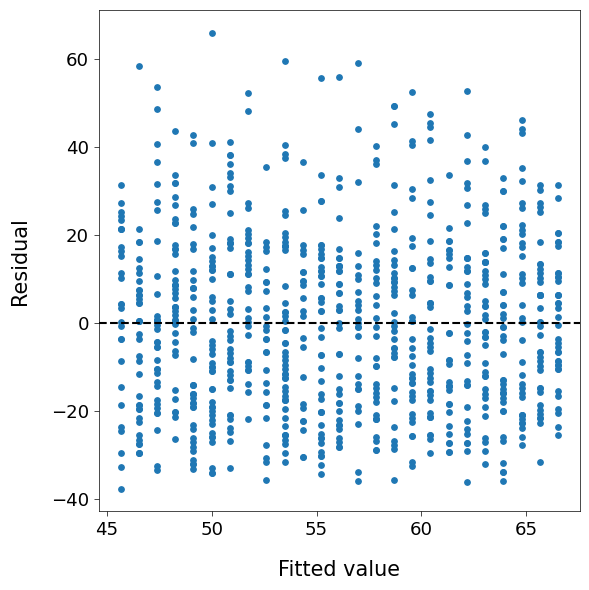

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(results.fittedvalues, results.resid, s=15)

ax.set_xlabel('Fitted value', fontsize=15, labelpad=15)
ax.set_ylabel('Residual', fontsize=15, labelpad=15)

ax.axhline(0, c='k', ls='--')

ax.tick_params(axis='both', which='both', color='black', width=0.5, labelsize=13)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.5)

fig.tight_layout()


The residuals appear to be fairly symmetrically distributed above and below the zero line, which supports the assumption of linearity in the model.  
However, the residuals are widely spread, showing a noticeable vertical dispersion.

3. #### Leverage

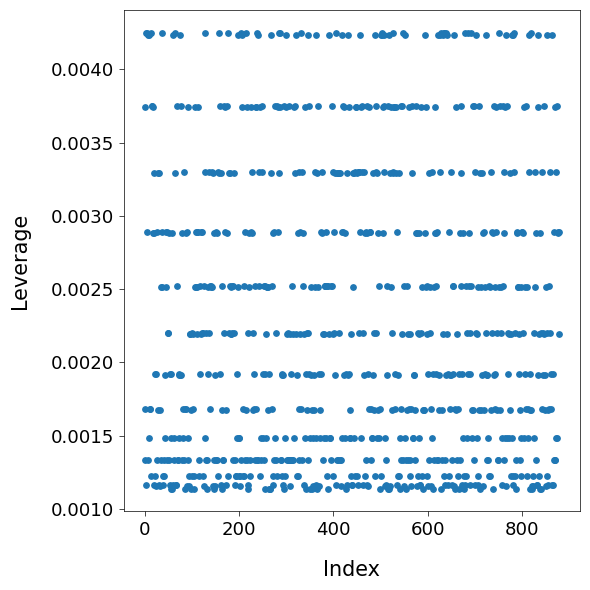

In [28]:
infl = results.get_influence()
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag, s=15)

ax.set_xlabel('Index', fontsize=15, labelpad=15)
ax.set_ylabel('Leverage', fontsize=15, labelpad=15)

ax.tick_params(axis='both', which='both', color='black', width=0.5, labelsize=13)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.5)

fig.tight_layout()

np.argmax(infl.hat_matrix_diag)
_ = np.argmax(infl.hat_matrix_diag)


Leverage values across the dataset are low, indicating that no individual observation exerts excessive influence on the model's predictions.  
The threshold for high leverage is 0.0045, and all points fall below this value.  
From this point of view, the model is very good.


---

# Multiple Linear Regression
- ## Numerical predictors
#### _Delivery Time (min)_ = _b0_ + _b1_ * _Distance (km)_ + _b2_ * _Preparation Time (min)_ + _e_

In [29]:
X = MS(['Distance_km', 'Preparation_Time_min']).fit_transform(Food)
X.columns = [variables.get(col, col) for col in X.columns]
y = Food['Delivery_Time_min']

model = sm.OLS(y, X)
results = model.fit()
summarize(results)

The results of the linear regression model indicate that distance and preparation time significantly influence food delivery time (p-values = 0.000).  
Specifically, delivery time increases by approximately 3.00 minutes per additional kilometer.  
It also increases by 1 minutes for each additional minute of preparation.  

In [30]:
R2 = results.rsquared
RSE = np.sqrt(results.scale)

print("R2:", round(R2, 3))
print("RSE:", round(RSE, 3))

R2: 0.723
RSE: 11.107


The linear regression model explains approximately 72% of the variance in food delivery time, indicating a strong fit.  
The residual standard error (RSE) is about 11 minutes, suggesting a moderate prediction error given the likely range of delivery times.  
Overall, the model performs well.

- ## Qualitative predictors

Now we examine the remaining variables, which are categorical.


Before starting, we adjust the variable _Courier Experience (yrs)_ by converting it into a categorical one, as previously mentioned during the analysis of correlations between numerical variables.  
To do this, we create a new column _Courier Experience_ with the following values:  
- _Low_ for experience from 0 to 2 years,  
- _Medium_ for experience from 3 to 5 years,  
- _High_ for experience greater than 5 years.


In [31]:
def categorize_experience(x):
    if x <= 2:
        return 'Low'
    elif x <= 5:
        return 'Medium'
    else:
        return 'High'

Food['Courier_Experience'] = Food['Courier_Experience_yrs'].apply(categorize_experience)

nan_before = Food['Courier_Experience_yrs'].isna().sum()
nan_after = Food['Courier_Experience'].isna().sum()
print(f"NaN prima della trasformazione: {nan_before}")
print(f"NaN dopo la trasformazione: {nan_after}")


NaN prima della trasformazione: 0
NaN dopo la trasformazione: 0


In [32]:
for col in Food.columns:
    if Food[col].dtype == 'object':
        col_name = variables.get(col, col)  
        print(f"{col_name}: {Food[col].unique()}")

Weather: ['Windy' 'Clear' 'Foggy' 'Rainy' 'Snowy']
Traffic Level: ['Low' 'Medium' 'High']
Time of Day: ['Afternoon' 'Evening' 'Night' 'Morning']
Vehicle Type: ['Scooter' 'Bike' 'Car']
Courier Experience: ['Low' 'Medium' 'High']


Before creating the new model, we verify that the categorical variables are not strongly correlated with each other, ensuring that each one contributes useful information to the model.  
Since the variables are not numerical, we cannot use a standard correlation matrix.  
Instead, we use Cramér's V, a statistical measure of association between two categorical variables, which ranges from 0 (no association) to 1 (perfect association).


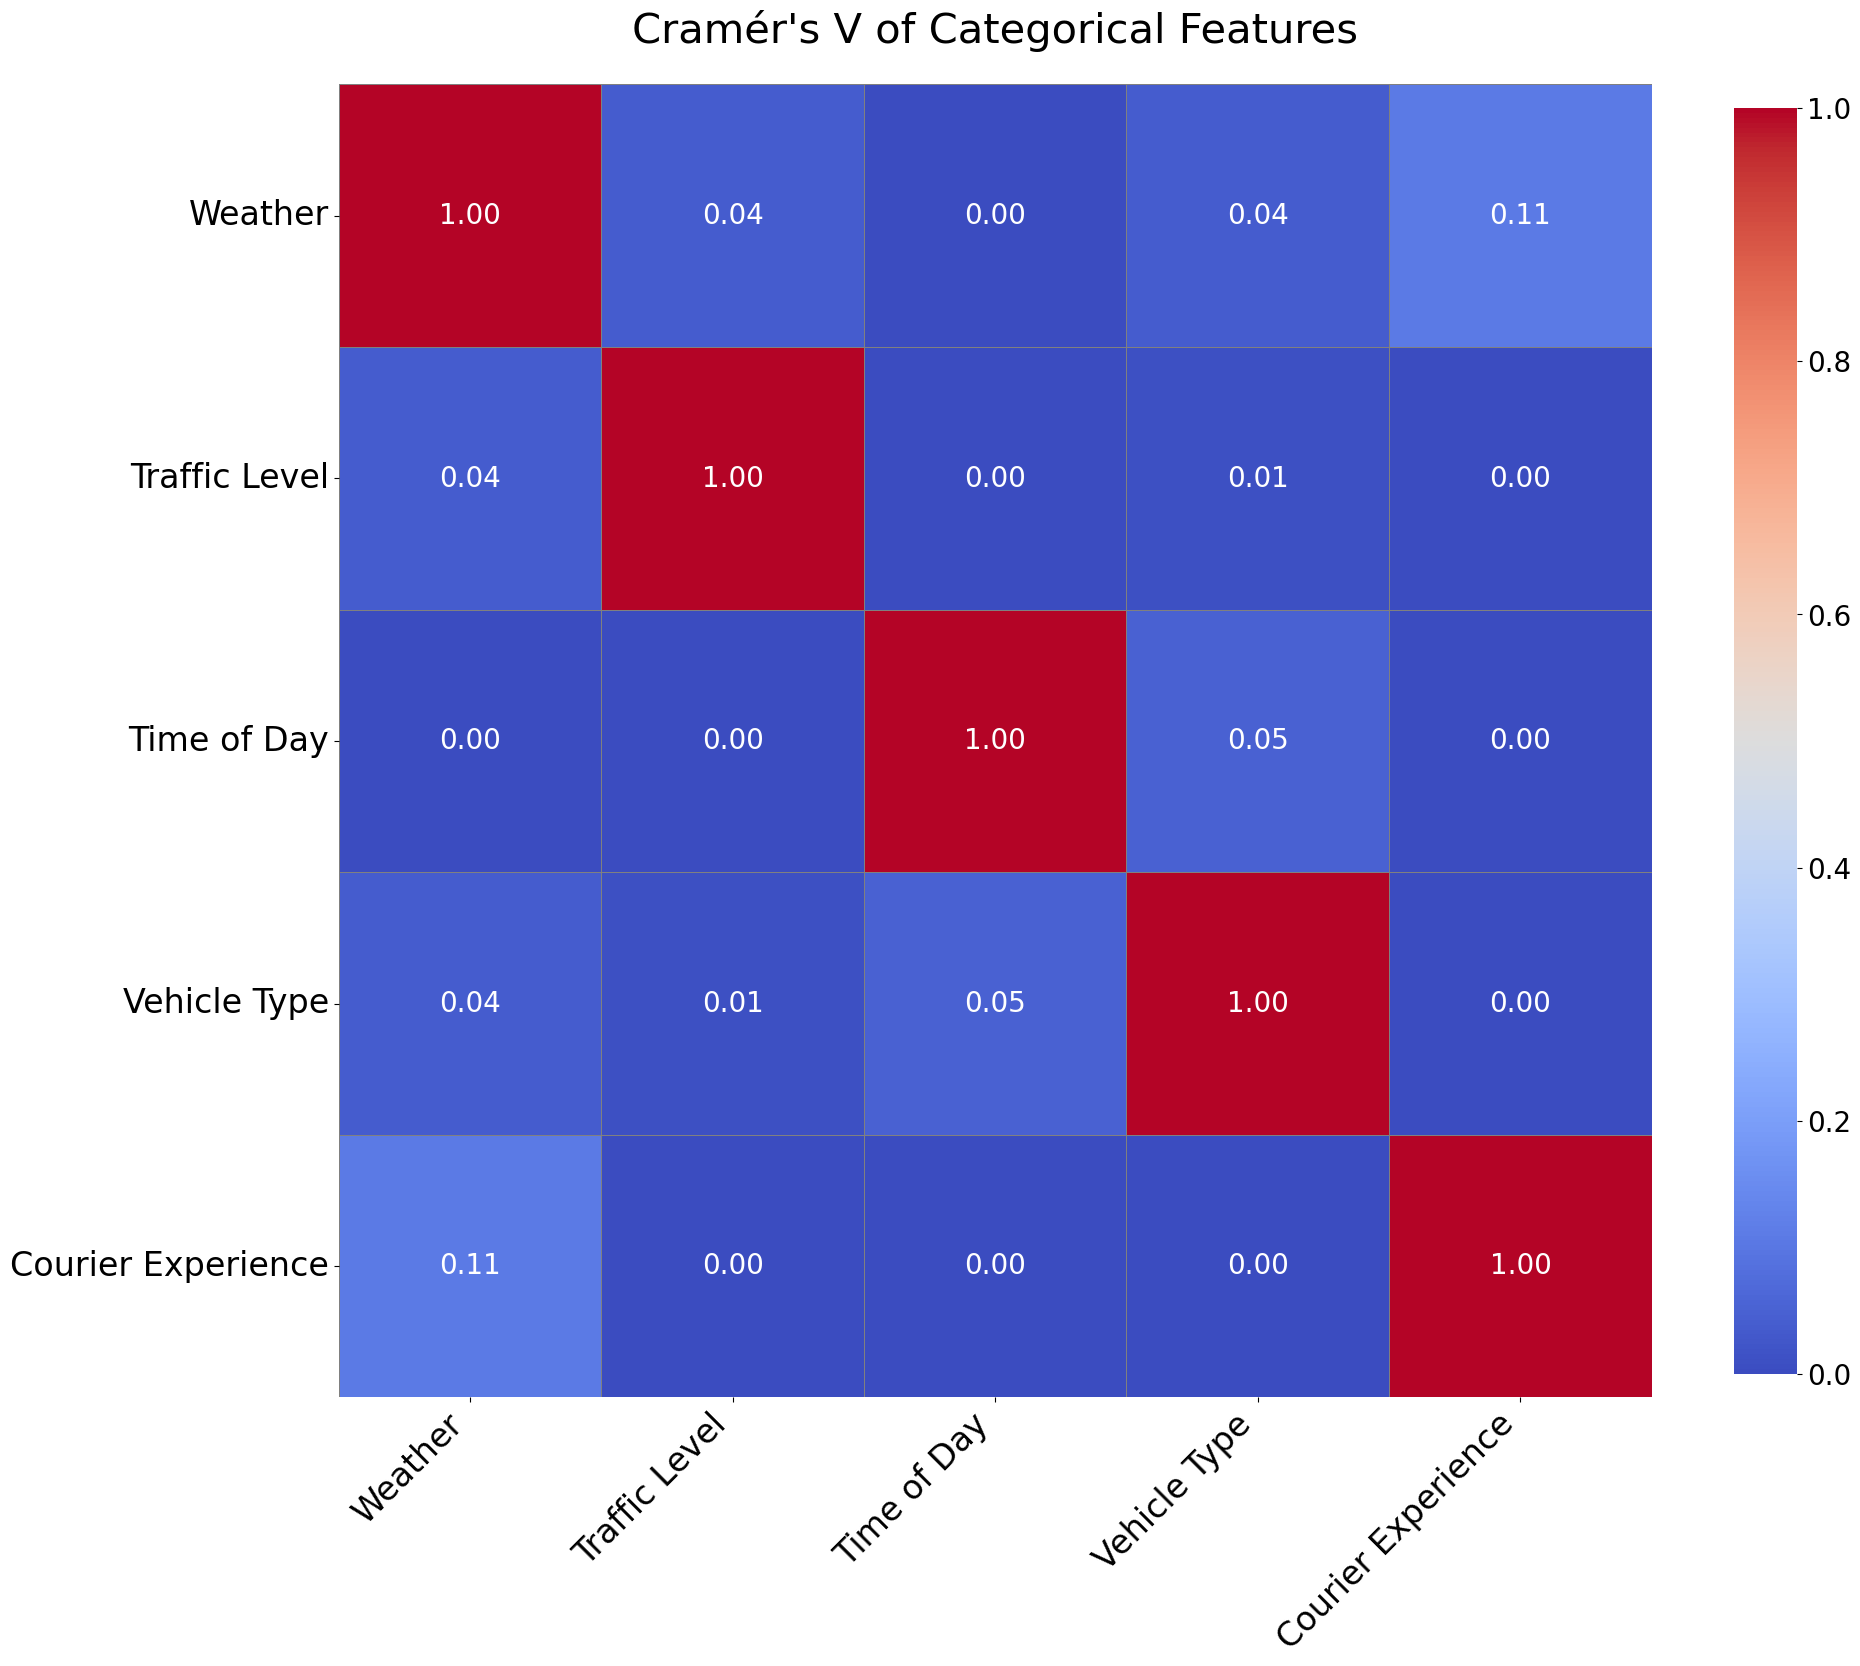

In [33]:
categorical = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Courier_Experience']
Food[categorical] = Food[categorical].astype('category')

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1)) 
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

cramer_matrix = pd.DataFrame(
    np.zeros((len(categorical), len(categorical))),
    index=categorical,
    columns=categorical
)

for var1 in categorical:
    for var2 in categorical:
        cramer_matrix.loc[var1, var2] = cramers_v(Food[var1], Food[var2])

cramer_matrix.columns = [variables.get(col, col) for col in cramer_matrix.columns]
cramer_matrix.index = [variables.get(row, row) for row in cramer_matrix.index]

plt.figure(figsize=(20, 18))
ax = sns.heatmap(
    cramer_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    linewidths=0.7,
    linecolor='gray',
    cbar_kws={'shrink': 0.8},
    annot_kws={"size": 20}
)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=24, rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=24, rotation=0)
ax.set_title("Cramér's V of Categorical Features", fontsize=30, pad=30)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()
plt.show()

The Cramér’s V matrix shows very low values, indicating that the categorical variables are essentially independent from each other.  
No significant associations emerge, suggesting that each variable provides distinct and non-redundant information to the model.


Using the tools from ISLP, we build a regression model that includes all variables, both numerical and categorical.  
Categorical variables are automatically handled by the library through one-hot encoding, a process that transforms each category into a separate binary variable.  
This allows the model to interpret categorical information in a numerical form suitable for linear regression.


In [34]:
model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Time_of_Day',
    'Vehicle_Type',
    'Preparation_Time_min',
    'Courier_Experience'
])

X = model.fit_transform(Food)
X.columns = [variables.get(col, col) for col in X.columns]
for i, col in enumerate(X.columns):
    if '[' in col and ']' in col:
        base_col = col.split('[')[0]
        if base_col in variables:
            X.columns.values[i] = col.replace(base_col, variables[base_col])
y = Food['Delivery_Time_min']

model = sm.OLS(y, X)
results = model.fit()
summarize(results)


From the regression results, several observations can be made:  
- _Distance (km)_ has a strong and significant positive effect on delivery time.  
- Adverse weather conditions like _Foggy_, _Rainy_, and _Snowy_ significantly increase delivery time, compared to _Clear_ weather.  
- _Traffic Level[Low]_ and _Medium_ significantly reduce delivery time compared to _High_ traffic, which is the baseline.  
- Different times of the day (_Morning_, _Evening_, _Night_) do not show statistically significant differences (p-values > 0.05) from the baseline (_Afternoon_).  
- Similarly, neither _Car_ nor _Scooter_ types show significant differences (p-values > 0.05) from the baseline vehicle (_Bike_), suggesting that vehicle type may not strongly influence delivery time in this model.  
- _Preparation Time (min)_ increases delivery time, as expected.  
- _Courier Experience[Low]_ and _Medium_ increase delivery time compared to the baseline _High_. 


In [35]:
R2 = results.rsquared
RSE = np.sqrt(results.scale)

print("R2:", round(R2, 3))
print("RSE:", round(RSE, 3))

R2: 0.804
RSE: 9.404


The linear regression model now explains approximately 80% of the variance in food delivery time, with a small improvement compared to the previous model (72%).  
The residual standard error is now about 9 minutes, suggesting a slight deterioration in prediction accuracy, with a lower error compared to the previous model (11 minutes).  
Overall, the model has improved in both explanatory power and prediction accuracy.


Observing the results, we notice that the p-values for _Veicle Type_ and _Time of Day_ are high.  
Before removing them, we aim to better understand why vehicle type does not affect delivery time.  
In real scenarios, using a car should reduce delivery time compared to using a bike.


In [36]:
vehicle_type_counts = Food['Vehicle_Type'].value_counts()
vehicle_type_counts.index.name = None
vehicle_type_counts.name = None
translated_column_name = variables.get('Vehicle_Type', 'Vehicle_Type')
print(f"{translated_column_name} counts:")
print(vehicle_type_counts.to_string())


Vehicle Type counts:
Bike       450
Scooter    259
Car        170


In [37]:
delivery_vehicle_mean = Food.groupby('Vehicle_Type', observed=False)['Delivery_Time_min'].mean()
delivery_vehicle_mean.index.name = None
delivery_vehicle_mean.name = None
translated_column_name = variables.get('Delivery_Time_min', 'Delivery_Time_min')
print(f"{translated_column_name} mean:")
print(delivery_vehicle_mean.to_string())


Delivery Time (min) mean:
Bike       56.473333
Car        56.841176
Scooter    54.965251


In [38]:
distance_vehicle_mean = Food.groupby('Vehicle_Type', observed=False)['Distance_km'].mean()
distance_vehicle_mean.index.name = None
distance_vehicle_mean.name = None
translated_column_name = variables.get('Distance_km', 'Distance_km')
print(f"{translated_column_name} mean:")
print(distance_vehicle_mean.to_string())


Distance (km) mean:
Bike       10.001067
Car        10.195471
Scooter     9.931197


We obtained the following results:  
- As previously mentioned, Cramer's V matrix shows that the association between _Vehicle Type_ and other categorical variables is nearly nonexistent (maximum value 0.05).  
- The distribution of the vehicles is unbalanced: 450 deliveries by bike, 259 by scooter, and 170 by car, despite this, each group has sufficient size to estimate means robustly.  
- The analysis of average delivery times per vehicle type revealed similar values: 56.47 minutes for bike, 54.96 for scooter, and 56.84 for car.  
- Similarly, the average distance traveled by each vehicle type was nearly the same (around 10 km) and this suggests that vehicle type is not associated with relevant differences in either distance or average time.  

These results justify the high p-value and the absence of effect may indicate that logistic differences between vehicles are offset by other operational factors not included in the dataset (e.g., city routes, assigned paths, traffic, etc.).


We now return to the model and remove, as previously anticipated, _Vehicle Type_ and _Time of Day_


In [39]:
categorical = ['Weather', 'Traffic_Level', 'Courier_Experience']
Food[categorical] = Food[categorical].astype('category')

model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Preparation_Time_min',
    'Courier_Experience',
])

X = model.fit_transform(Food)
X.columns = [variables.get(col, col) for col in X.columns]
for i, col in enumerate(X.columns):
    if '[' in col and ']' in col:
        base_col = col.split('[')[0]
        if base_col in variables:
            X.columns.values[i] = col.replace(base_col, variables[base_col])
y = Food['Delivery_Time_min']

model = sm.OLS(y, X)
results = model.fit()
summarize(results)

In [40]:
R2 = results.rsquared
RSE = np.sqrt(results.scale)

print("R2:", round(R2, 3))
print("RSE:", round(RSE, 3))

R2: 0.803
RSE: 9.41


By removing the two variables, we obtained a simpler and more interpretable model.  
This was achieved without losing the good performance of the previous full model: R² and RSE values remain nearly identical to before.


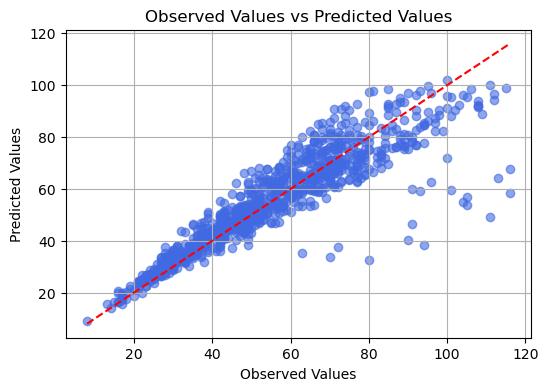

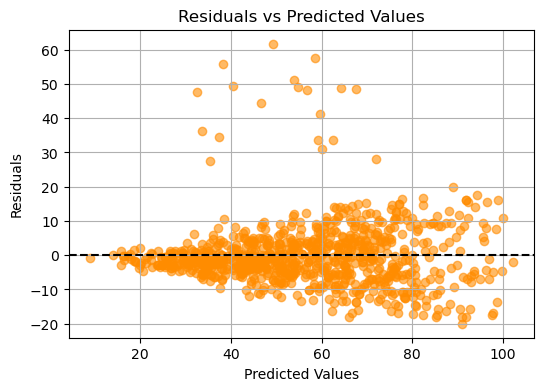

In [41]:
y_pred = results.fittedvalues

plt.figure(figsize=(6, 4))
plt.scatter(y, y_pred, alpha=0.6, color='royalblue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Observed Values vs Predicted Values')
plt.grid(True)
plt.show()

residuals = results.resid

plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.6, color='darkorange')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()


The model is good, but from the second plot, we can observe a clear cone-shaped pattern, with residuals starting from 0 and ranging between -20 and +20.  
This pattern indicates heteroscedasticity, meaning the variance of the residuals increases as the predicted values grow.  
In other words, the model's error is not constant across all levels of prediction, but rather increases as the predicted values move further from 0.  
A solution to this phenomenon is to apply logarithmic, square root or Box-Cox transformations to the model.  
These transformations stabilize the variance by compressing the scale of larger predicted values, making the residuals more homoscedastic and improving the model's assumptions.


Transformation: log


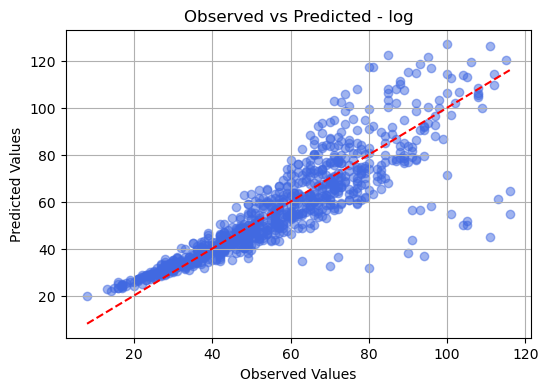

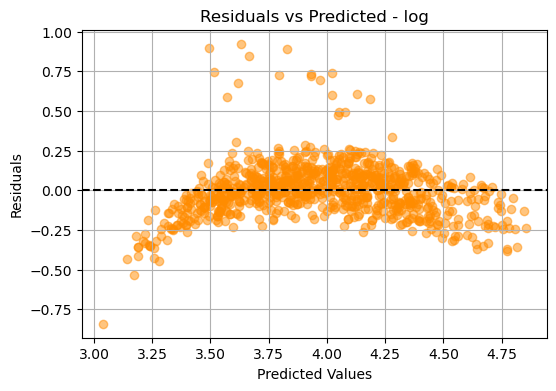


Transformation: sqrt


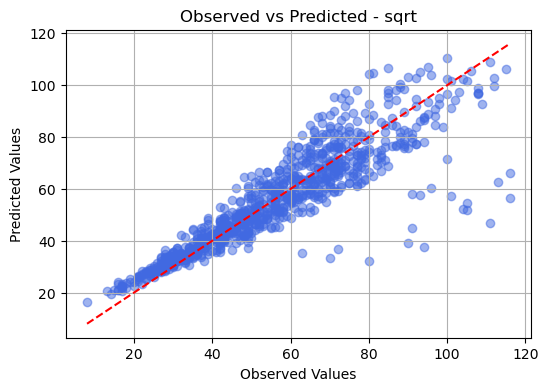

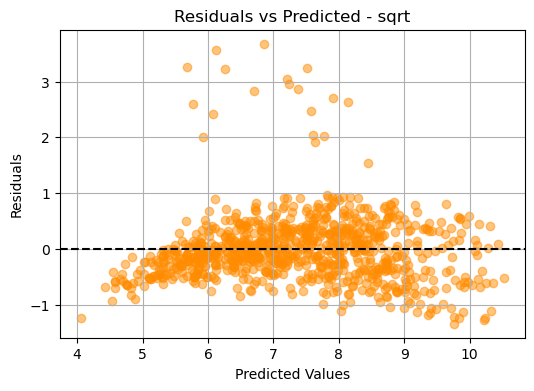


Transformation: boxcox


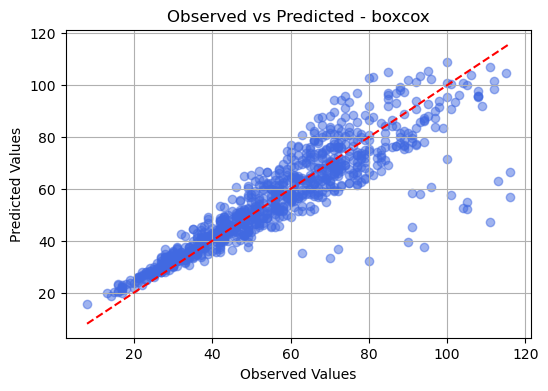

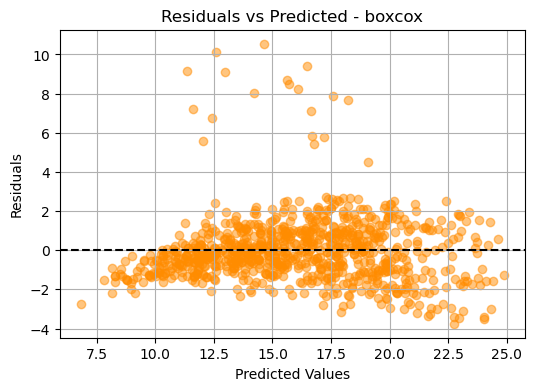


Metrics for each transformation:
log: R² = 0.823, MSE = 116.553, RMSE = 10.796
sqrt: R² = 0.827, MSE = 94.002, RMSE = 9.695
boxcox: R² = 0.825, MSE = 92.151, RMSE = 9.600


In [43]:
def transform_y(y, method):
    if method == 'log':
        return np.log1p(y)
    elif method == 'sqrt':
        return np.sqrt(y)
    elif method == 'boxcox':
        if any(y <= 0):
            raise ValueError("Box-Cox transformation requires y to be strictly positive.")
        y_transformed, lmbda = boxcox(y)
        return y_transformed, lmbda
    else:
        raise ValueError(f"Unknown transformation: {method}")

transformations = ['log', 'sqrt', 'boxcox']

results_summary = {}

categorical = ['Weather', 'Traffic_Level', 'Courier_Experience']
Food[categorical] = Food[categorical].astype('category')

model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Preparation_Time_min',
    'Courier_Experience',
])

X = model.fit_transform(Food)
y = Food['Delivery_Time_min']

for transform in transformations:
    print(f"\nTransformation: {transform}")
    
    if transform == 'boxcox':
        y_transformed, lmbda = transform_y(y, transform)
    else:
        y_transformed = transform_y(y, transform)

    mod = sm.OLS(y_transformed, X)
    res = mod.fit()

    y_pred = res.predict(X)

    if transform == 'log':
        y_pred_plot = np.expm1(y_pred)
    elif transform == 'sqrt':
        y_pred_plot = np.square(y_pred)
    elif transform == 'boxcox':
        if lmbda == 0:
            y_pred_plot = np.exp(y_pred)
        else:
            y_pred_plot = np.power(y_pred * lmbda + 1, 1 / lmbda)
    else:
        y_pred_plot = y_pred

    mse = mean_squared_error(y, y_pred_plot)
    rmse = np.sqrt(mse)
    r2 = res.rsquared

    results_summary[transform] = {'R2': r2, 'MSE': mse, 'RMSE': rmse}

    plt.figure(figsize=(6, 4))
    plt.scatter(y, y_pred_plot, alpha=0.5, color='royalblue')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
    plt.xlabel('Observed Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Observed vs Predicted - {transform}')
    plt.grid(True)
    plt.show()

    residuals = y_transformed - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, color='darkorange', alpha=0.5)
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Predicted - {transform}')
    plt.grid(True)
    plt.show()

print("\nMetrics for each transformation:")
for key, metrics in results_summary.items():
    print(f"{key}: R² = {metrics['R2']:.3f}, MSE = {metrics['MSE']:.3f}, RMSE = {metrics['RMSE']:.3f}")

Observing the results from the plots, no clear improvement is noticeable.  
Moreover, the R² values are similar to the original model.  
Therefore, we prefer to continue our work with the non-transformed model.  


---

# Cross-Validation

Cross-validation helps evaluate how well the model generalizes to unseen data.  
By testing the model on a separate validation set, we can detect overfitting and assess real-world performance.  
In this case, we split the dataset into a training set _Food train_ and a validation set _Food valid_.  
We explicitly define the size of the validation set (440 samples), which is exactly half of the total dataset, to ensure a consistent and controlled evaluation.  


In [176]:
Food_train , Food_valid = train_test_split(Food, test_size=440, random_state=0) 

In [177]:
categorical = ['Weather', 'Traffic_Level', 'Courier_Experience']
Food_train[categorical] = Food_train[categorical].astype('category')

cv_model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Preparation_Time_min',
    'Courier_Experience',
])

X_train = cv_model.fit_transform(Food_train)
y_train = Food_train['Delivery_Time_min']


model = sm.OLS(y_train, X_train)
results = model.fit()

In [178]:
X_valid = cv_model.fit_transform(Food_valid)
y_valid = Food_valid['Delivery_Time_min']

valid_pred = results.predict(X_valid)
MSE = np.mean((y_valid - valid_pred)**2)
RMSE = np.sqrt(MSE)

print("MSE:", f"{MSE:.3f}") 
print("RMSE:", f"{RMSE:.3f}")

MSE: 96.075
RMSE: 9.802


- ## Leave-one-out cross-validation


In [179]:
categorical = ['Weather', 'Traffic_Level', 'Courier_Experience']
Food[categorical] = Food[categorical].astype('category')

loocv_model = sklearn_sm(sm.OLS, MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Preparation_Time_min',
    'Courier_Experience',
]))

X = Food.drop(columns=['Delivery_Time_min'])
y = Food['Delivery_Time_min']

cv_results = cross_validate(loocv_model, X, y, cv=Food.shape[0])
MSE = np.mean(cv_results['test_score'])
RMSE = np.sqrt(MSE)

print("MSE:", f"{MSE:.3f}") 
print("RMSE:", f"{RMSE:.3f}")


MSE: 89.766
RMSE: 9.474


Leave-one-out cross-validation is more precise but the most expensive in terms of both time and computation.  
This is because it requires the model to be trained multiple times, with each iteration leaving out a single data point for validation.  
Indeed, the results obtained in terms of MSE and RMSE were slightly improved compared to the previous cross-validation, but it took approximately 30 seconds, compared to 0 seconds for the previous method.


- ## K-fold cross-validation

In [180]:
categorical = ['Weather', 'Traffic_Level', 'Courier_Experience']
Food[categorical] = Food[categorical].astype('category')

kf_model = sklearn_sm(sm.OLS, MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Preparation_Time_min',
    'Courier_Experience'
]))

X = Food.drop(columns=['Delivery_Time_min'])
y = Food['Delivery_Time_min']

kf = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_validate(kf_model, X, y, cv=kf)
MSE = np.mean(cv_results['test_score'])
RMSE = np.sqrt(MSE)

print("MSE:", f"{MSE:.3f}") 
print("RMSE:", f"{RMSE:.3f}")


MSE: 89.613
RMSE: 9.466


K-fold generally strikes a balance between precision and computational cost, but in our case it actually performs better.  
This is probably due to the presence of outliers, which make LOOCV less accurate and K-fold more robust and general.  
Moreover, the execution time is very close to that of the first cross-validation method, so for our analysis, K-fold is better from every point of view.



---

# Shrinkage Methods

We continue the analysis of the model using shrinkage methods.  
These methods allow setting the coefficients of variables to zero.  
To do this, it makes sense to return to a model with all variables.  
This means adding back the categorical variables _Time of Day_ and _Vehicle Type_.  
It is also important to normalize the model, as this ensures all variables are on the same scale. 

In [181]:
categorical = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Courier_Experience']
Food[categorical] = Food[categorical].astype('category')

model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Time_of_Day',
    'Vehicle_Type',
    'Preparation_Time_min',
    'Courier_Experience'
])

X = model.fit_transform(Food)
y = Food['Delivery_Time_min']

numerical_columns = ['Distance_km', 'Preparation_Time_min']

scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

X.columns = [variables.get(col, col) for col in X.columns]
for i, col in enumerate(X.columns):
    if '[' in col and ']' in col:
        base_col = col.split('[')[0]
        if base_col in variables:
            X.columns.values[i] = col.replace(base_col, variables[base_col])

model = sm.OLS(y, X)
results = model.fit()

summarize(results)


- ## Ridge regression

We begin by splitting the database into train and test sets.  
Next, we search for the optimal lambda for ridge regression.  


In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
lambda_values = np.logspace(-2, 4, 300) 


In [183]:
pipeline = make_pipeline(StandardScaler(), Ridge())

param_grid = {'ridge__alpha': lambda_values}
ridge_cv = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=10) 
ridge_cv.fit(X_train, y_train)
best_alpha = ridge_cv.best_params_['ridge__alpha']
print(f"Best Ridge lambda: {best_alpha:.3f}") 



Best Ridge lambda: 5.359


We evaluate the test set using the lambda found.

In [184]:
ridge_best = ridge_cv.best_estimator_
ridge_pred = ridge_best.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)

coefficients = np.round(ridge_best.named_steps['ridge'].coef_, 3)

coeff_df = pd.DataFrame({'Coefficient': coefficients}, index=X_train.columns)

def style_coeff(val):
    styles = []
    if val >= 0:
        styles.append('color: green')
    else:
        styles.append('color: red')
    styles.append('font-weight: bold')
    return '; '.join(styles)

row_styles = [
    {'selector': f'tbody tr:nth-child({i+1})', 'props': [('opacity', '0.35')]}
    for i, val in enumerate(coeff_df['Coefficient'])
    if abs(val) < 0.1
]

coeff_df_styled = (
    coeff_df.style
    .format({'Coefficient': '{:.3f}'})
    .map(style_coeff, subset=['Coefficient'])
    .set_table_styles(
        [{'selector': 'th.row_heading', 'props': [('font-weight', 'bold')]}] + row_styles
    )
)

coeff_df_styled


From the results, we see that the less significant variables (also observed in previous models and methods) have coefficients very close to zero for ridge regression.  
This occurs because ridge regression shrinks coefficients of less relevant variables toward zero, improving model generalization.  
We also notice that the intercept is exactly zero.  

In [185]:
MSE = ridge_mse
RMSE = np.sqrt(MSE)

print("MSE:", f"{MSE:.3f}") 
print("RMSE:", f"{RMSE:.3f}")

MSE: 96.687
RMSE: 9.833


The results in this case are similar to those obtained previously with the three cross-validation methods (50%, LOOCV, and KF), with a slight improvement of about 2% referring to the RMSE.


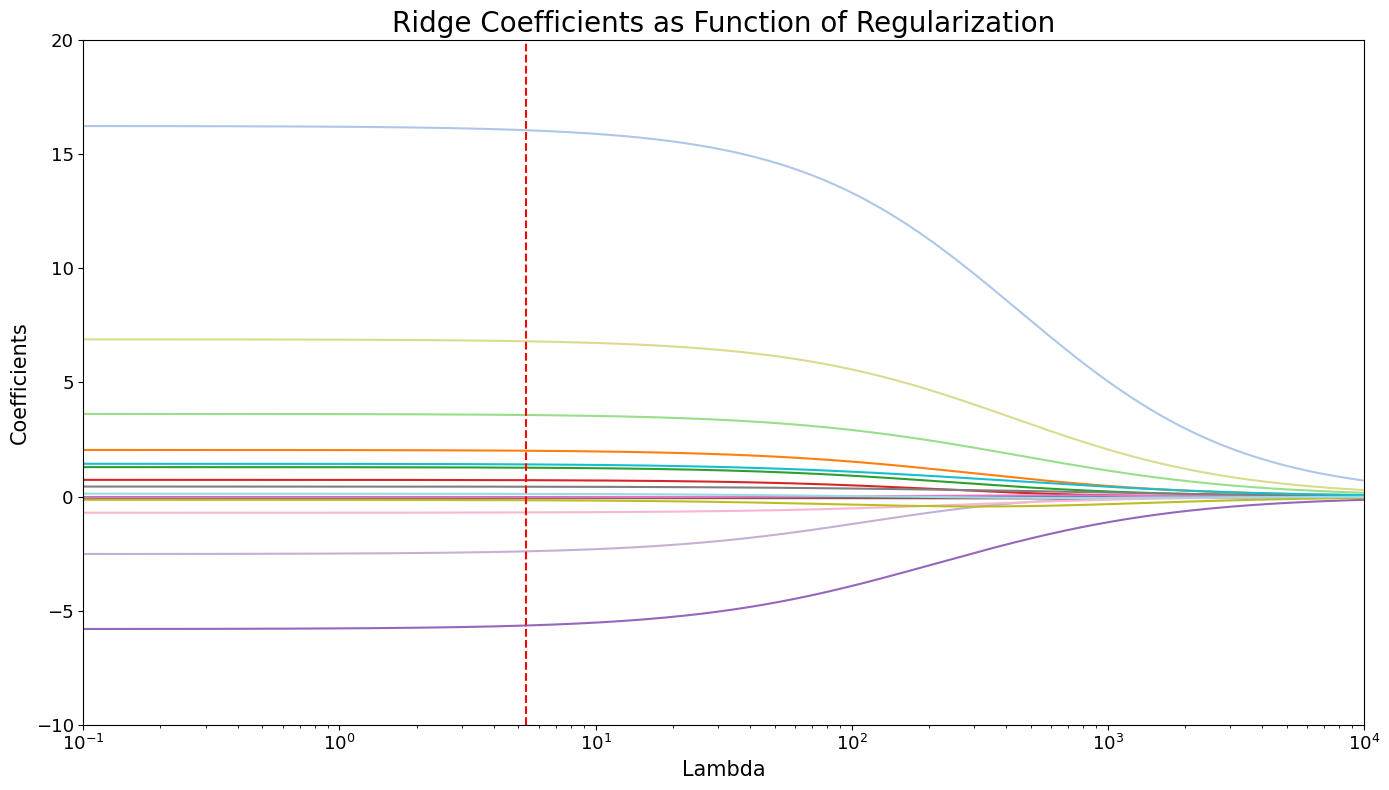

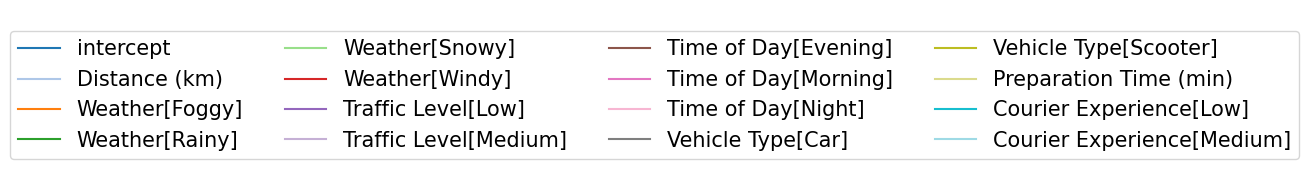

In [186]:
coefs = []
feature_names = X_train.columns

for a in lambda_values:
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=a))
    pipe.fit(X_train, y_train)
    coefs.append(pipe.named_steps['ridge'].coef_)

coefs = np.array(coefs)

fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.tab20(np.linspace(0, 1, len(feature_names)))

for idx, name in enumerate(feature_names):
    ax.plot(lambda_values, coefs[:, idx], label=name, color=colors[idx])

ax.set_xscale('log')
plt.xlabel('Lambda', fontsize=15)  
plt.axvline(best_alpha, color='r', linestyle='--')
plt.ylabel('Coefficients', fontsize=15) 
plt.title('Ridge Coefficients as Function of Regularization', fontsize=20)  
plt.ylim(-10, 20)
plt.xlim(1e-1, 1e4)
plt.xticks(fontsize=13) 
plt.yticks(fontsize=13)  
plt.tight_layout()


handles, labels = ax.get_legend_handles_labels()

plt.show()

fig_legend = plt.figure(figsize=(12, 2))
ax_leg = fig_legend.add_subplot(111)
ax_leg.axis("off") 

ax_leg.legend(handles=handles, labels=labels,
              loc='center', ncol=4, fontsize=15)  

fig_legend.tight_layout()
plt.show()

The results of the coefficients can also be seen in this graph, at the point corresponding to the red dashed line, which indicates the optimal lambda.  
It is noticeable that the important variables are those farthest from zero.  
It is also noticeable that ridge regression drives the coefficients toward zero as lambda increases.


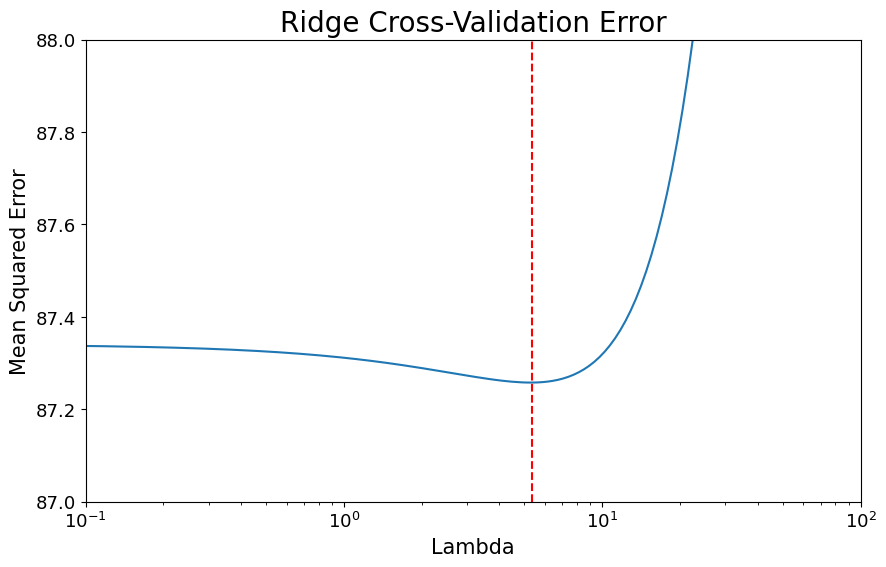

In [187]:
mean_test_scores = -ridge_cv.cv_results_['mean_test_score'] 
alphas = ridge_cv.param_grid['ridge__alpha']

plt.figure(figsize=(10, 6))
plt.semilogx(alphas, mean_test_scores)
plt.axvline(best_alpha, color='r', linestyle='--')
plt.xlabel('Lambda', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.title('Ridge Cross-Validation Error', fontsize=20)
plt.ylim(87, 88)
plt.xlim(1e-1, 1e2)
plt.xticks(fontsize=13) 
plt.yticks(fontsize=13) 
plt.show()


In this other plot, we can see that the minimum MSE is found at the optimal lambda.


- ## Lasso regression

We will now proceed in the same manner with lasso regression.


In [188]:
lasso_pipe = make_pipeline(StandardScaler(), Lasso(max_iter=10000))

lasso_cv = GridSearchCV(lasso_pipe, 
                       {'lasso__alpha': lambda_values},
                       scoring='neg_mean_squared_error',
                       cv=10)
lasso_cv.fit(X_train, y_train)
best_alpha = lasso_cv.best_params_['lasso__alpha']
print(f"Best Lasso lambda: {best_alpha:.3f}")

Best Lasso lambda: 0.146


In [189]:
lasso_best = lasso_cv.best_estimator_
lasso_pred = lasso_best.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)

print(f"Number of initial coefficients: {len(feature_names)}")

final_coefs = np.round(lasso_best.named_steps['lasso'].coef_, 3)
print(f"Number of non-zero coefficients: {np.sum(final_coefs != 0)}")

coeff_df = pd.DataFrame({'Coefficient': final_coefs}, index=feature_names)

def style_coeff(val):
    styles = []
    if val == 0:
        styles.append('color: gray')
    elif val > 0:
        styles.append('color: green')
    else:
        styles.append('color: red')
    styles.append('font-weight: bold')
    return '; '.join(styles)

row_styles = [
    {'selector': f'tbody tr:nth-child({i+1})', 'props': [('opacity', '0.35')]}
    for i, val in enumerate(coeff_df['Coefficient'])
    if val == 0.000
]

coeff_df_styled = (
    coeff_df.style
    .format({'Coefficient': '{:.3f}'})
    .map(style_coeff, subset=['Coefficient'])
    .set_table_styles(
        [{'selector': 'th.row_heading', 'props': [('font-weight', 'bold')]}] + row_styles
    )
)

coeff_df_styled


Number of initial coefficients: 16
Number of non-zero coefficients: 12


With lasso regression, the less significant variables are driven exactly to zero, allowing for model simplification.  
Similarly, the intercept remains zero in this case as well.


In [190]:
MSE = lasso_mse
RMSE = np.sqrt(MSE)

print("MSE:", f"{MSE:.3f}") 
print("RMSE:", f"{RMSE:.3f}")

MSE: 97.586
RMSE: 9.879


The results compared to ridge regression are practically identical.


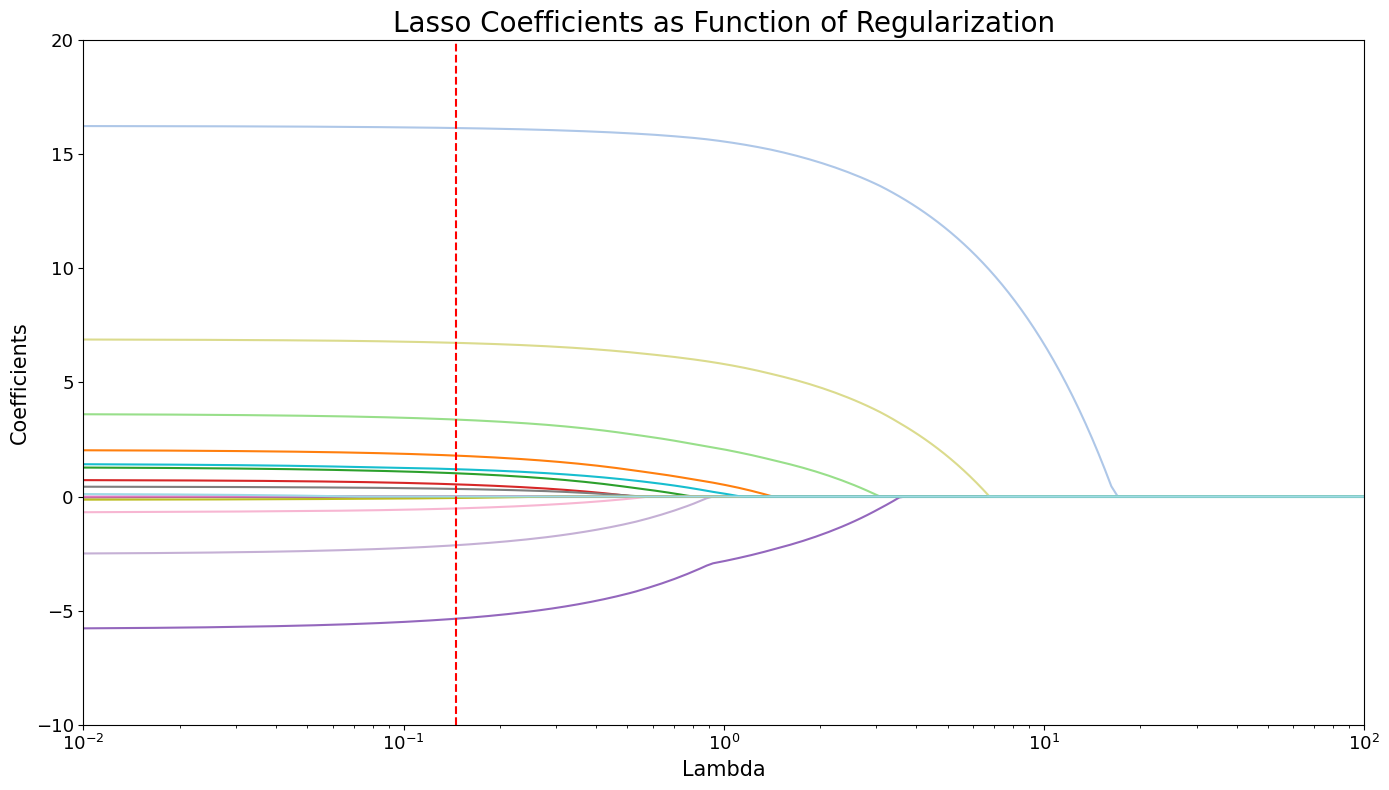

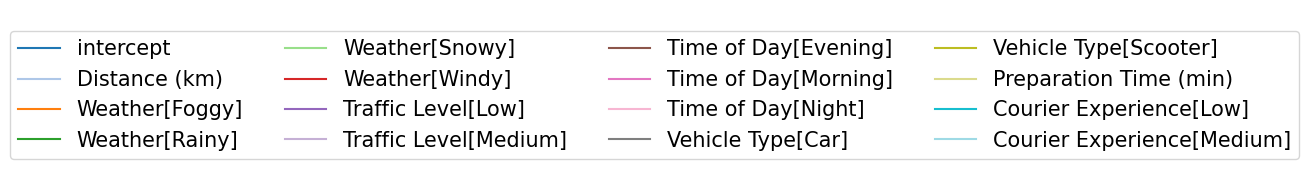

In [191]:
coefs = []
feature_names = X_train.columns

for a in lambda_values:
    pipe = make_pipeline(StandardScaler(), Lasso(alpha=a, max_iter=10000))
    pipe.fit(X_train, y_train)
    coefs.append(pipe.named_steps['lasso'].coef_)

coefs = np.array(coefs)

fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.tab20(np.linspace(0, 1, len(feature_names)))

for idx, name in enumerate(feature_names):
    ax.plot(lambda_values, coefs[:, idx], label=name, color=colors[idx])

ax.set_xscale('log')
plt.xlabel('Lambda', fontsize=15)  
plt.axvline(best_alpha, color='r', linestyle='--')
plt.ylabel('Coefficients', fontsize=15) 
plt.title('Lasso Coefficients as Function of Regularization', fontsize=20)  
plt.ylim(-10, 20)
plt.xlim(1e-2, 1e2)
plt.xticks(fontsize=13) 
plt.yticks(fontsize=13)  
plt.tight_layout()

handles, labels = ax.get_legend_handles_labels()

plt.show()

fig_legend = plt.figure(figsize=(12, 2))
ax_leg = fig_legend.add_subplot(111)
ax_leg.axis("off")

ax_leg.legend(handles=handles, labels=labels,
              loc='center', ncol=4, fontsize=15)  

fig_legend.tight_layout()
plt.show()


Unlike the same plot for ridge regression, we notice that in lasso regression, the coefficients go exactly to zero as the optimal lambda increases.


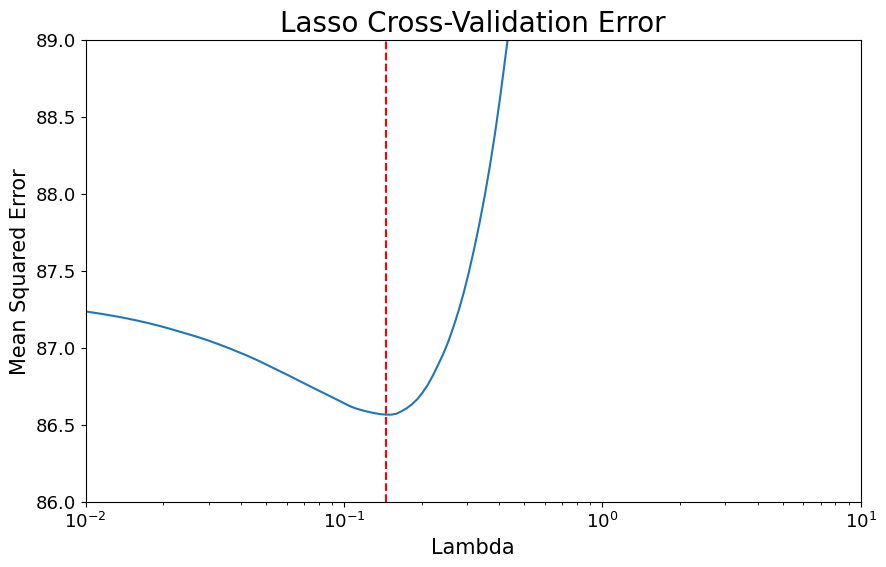

In [192]:
mean_test_scores = -lasso_cv.cv_results_['mean_test_score'] 
alphas = lasso_cv.param_grid['lasso__alpha']

plt.figure(figsize=(10, 6))
plt.semilogx(alphas, mean_test_scores)
plt.axvline(best_alpha, color='r', linestyle='--')
plt.xlabel('Lambda', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.title('Lasso Cross-Validation Error', fontsize=20)
plt.ylim(86, 89)
plt.xlim(1e-2, 1e1)
plt.xticks(fontsize=13) 
plt.yticks(fontsize=13) 
plt.show()

As with the optimal lambda for ridge regression, the optimal lambda for lasso regression is also at the minimum of the MSE function.


---

# Regression Trees

Regression trees are decision tree models that split the data into regions based on input variables, aiming to predict the output by minimizing variability within each region.  
We return to a non-normalized model, as normalization is not needed because tree-based methods are not sensitive to the scale of the variables.  
As with previous methods, we split the data into train and test sets and use a DecisionTreeRegressor.

In [193]:
categorical = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Courier_Experience']
Food[categorical] = Food[categorical].astype('category')

model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Time_of_Day',
    'Vehicle_Type',
    'Preparation_Time_min',
    'Courier_Experience'
])

X = model.fit_transform(Food)
y = Food['Delivery_Time_min']

X.columns = [variables.get(col, col) for col in X.columns]
for i, col in enumerate(X.columns):
    if '[' in col and ']' in col:
        base_col = col.split('[')[0]
        if base_col in variables:
            X.columns.values[i] = col.replace(base_col, variables[base_col])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=1
)

In [194]:
tree_model = DecisionTreeRegressor(random_state=2)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=2)

In [195]:
feature_importances = tree_model.feature_importances_
feature_names = tree_model.feature_names_in_

features_with_importances = list(zip(feature_names, feature_importances))

print("Regression Tree:")
print(f"Tree depth: {tree_model.get_depth()}")
print(f"Number of leaves: {tree_model.get_n_leaves()}")

importance_df = pd.DataFrame({
    'Importance': np.round(feature_importances, 3)
}, index=feature_names)

def style_importance(val):
    return 'font-weight: bold'

row_styles = [
    {'selector': f'tbody tr:nth-child({i+1})', 'props': [('opacity', '0.35')]}
    for i, val in enumerate(importance_df['Importance'])
    if val < 0.05
]

importance_df_styled = (
    importance_df.style
    .format({'Importance': '{:.3f}'})
    .map(style_importance, subset=['Importance']) 
    .set_table_styles(
        [{'selector': 'th.row_heading', 'props': [('font-weight', 'bold')]}] + row_styles
    )
)

importance_df_styled


Regression Tree:
Tree depth: 16
Number of leaves: 407


The resulting tree is very complex, with 16 levels and 407 leaves, suggesting strong overfitting.  
Regarding variable importance information, the results are consistent with those observed in the previous models.

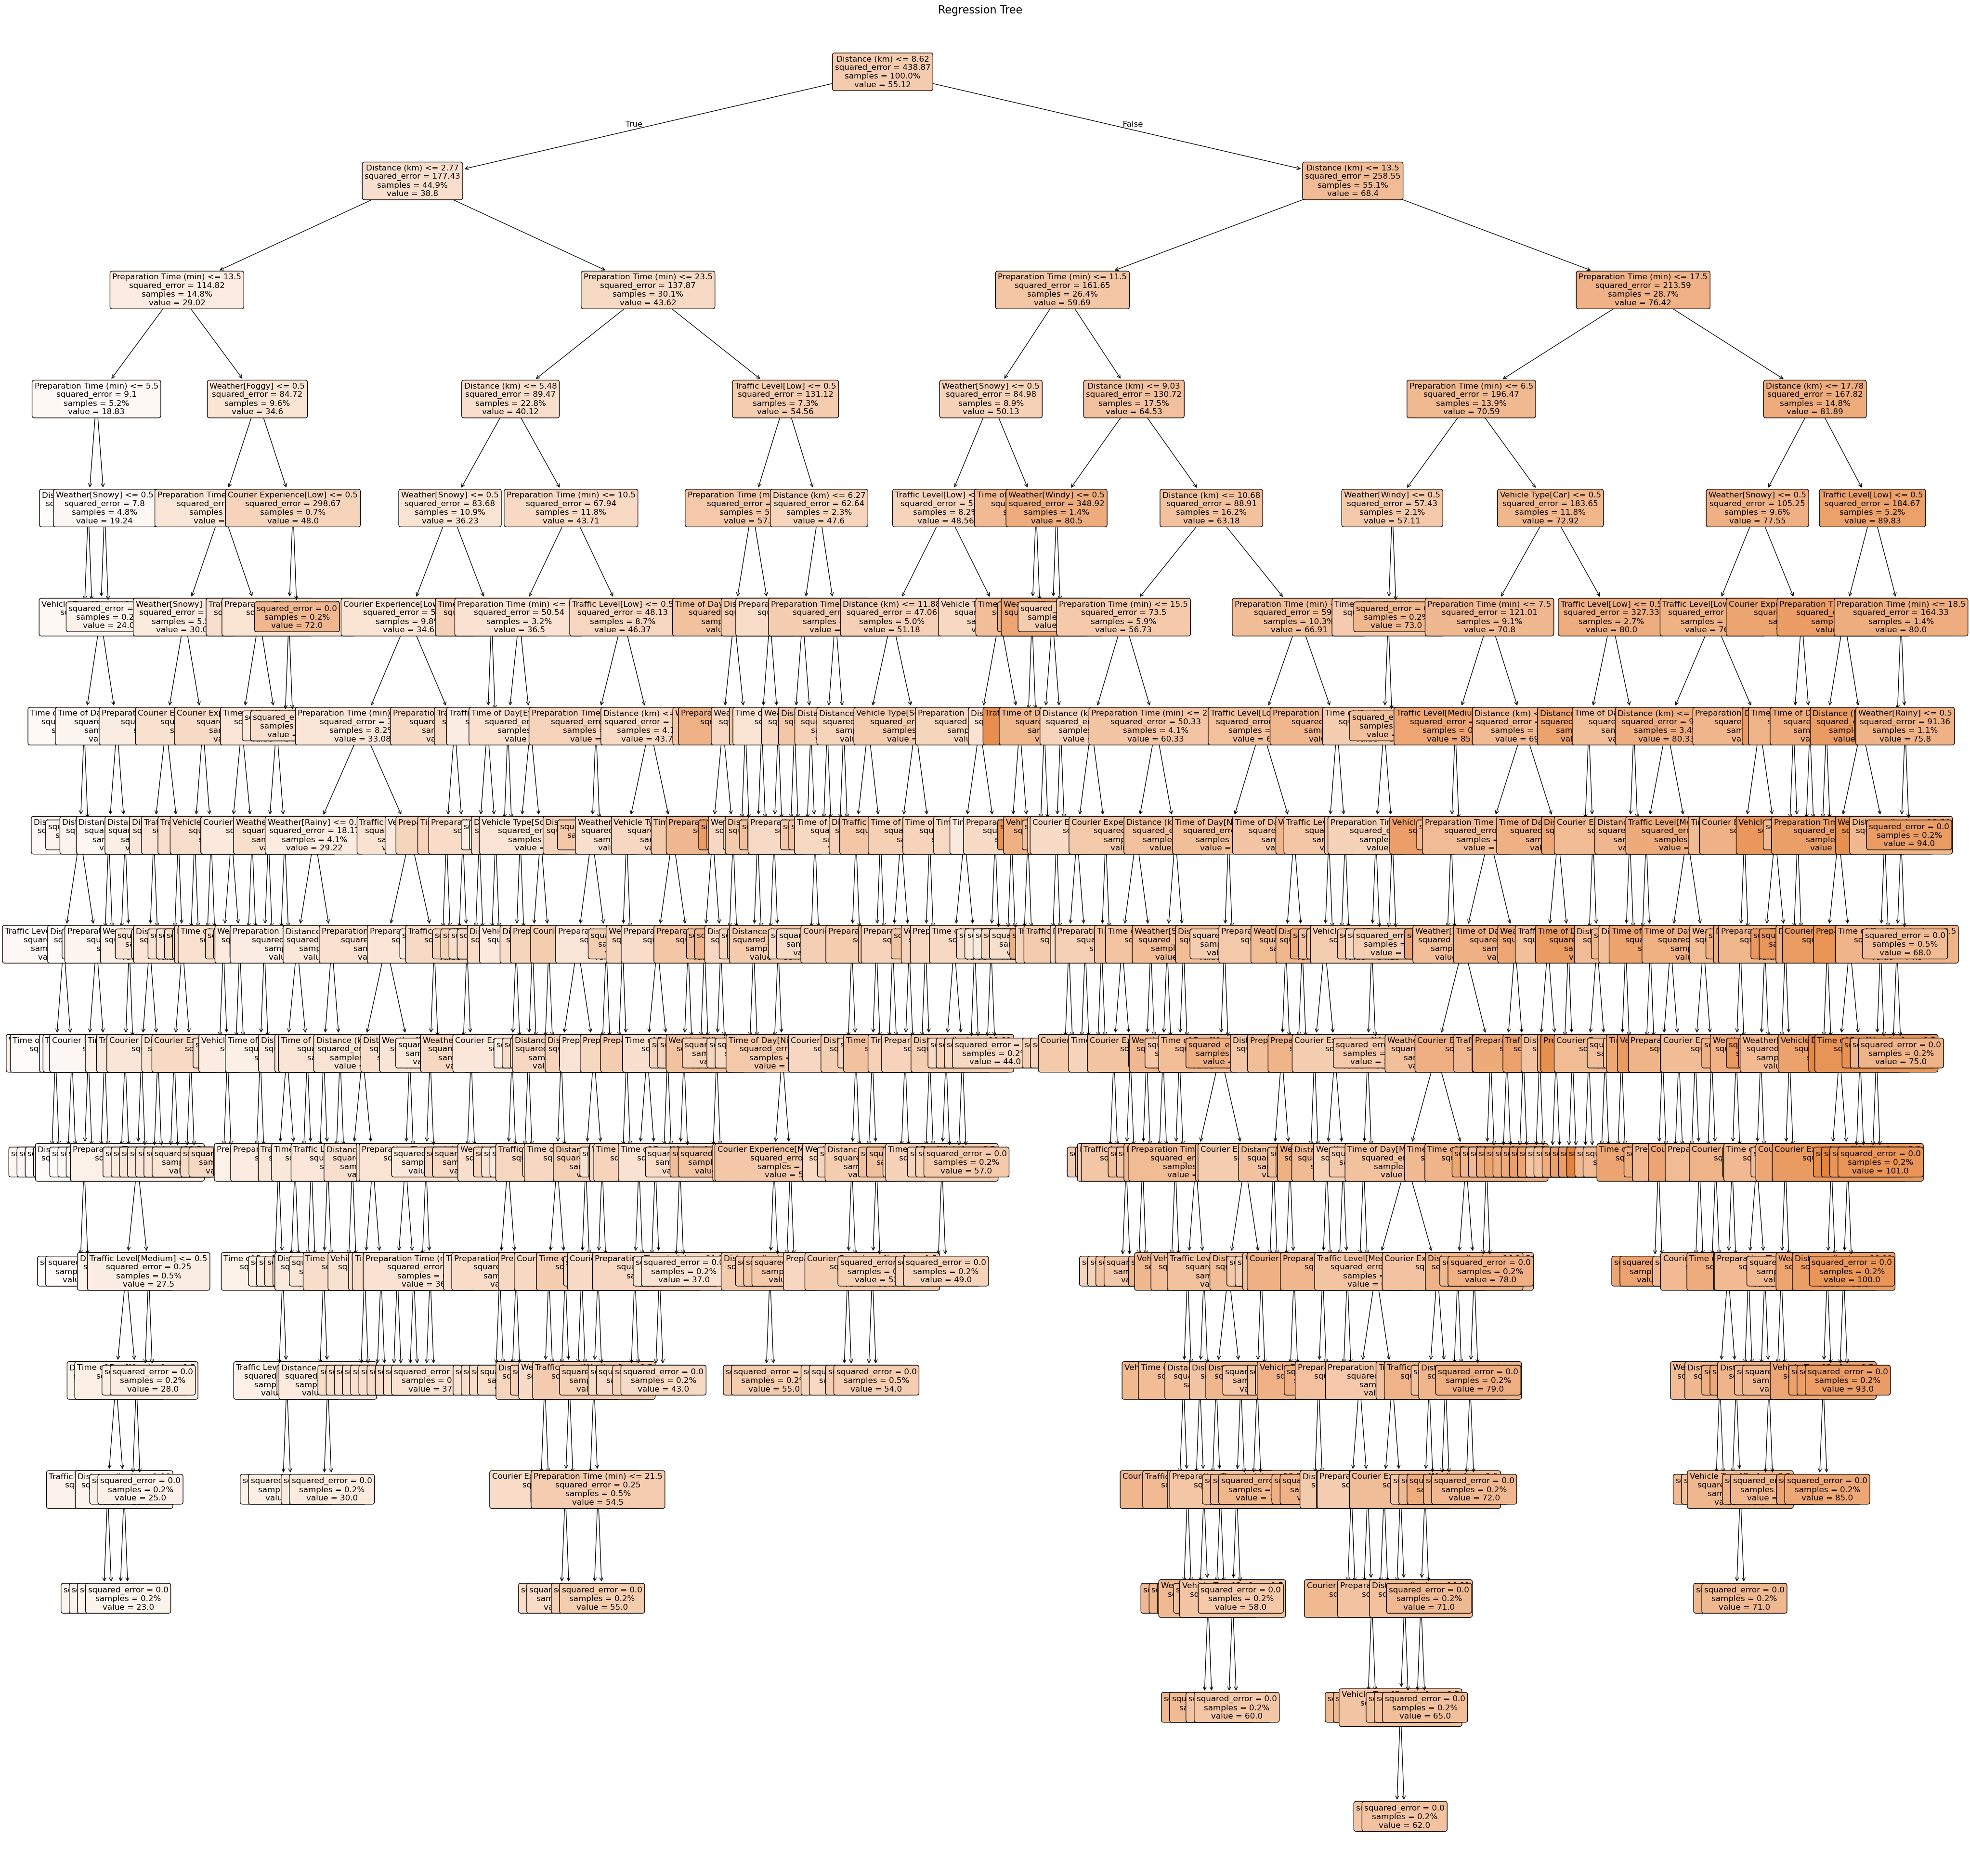

In [196]:
plt.figure(figsize=(50, 50)) 
plot_tree(tree_model, 
          feature_names=X.columns, 
          filled=True, 
          rounded=True, 
          proportion=True,  
          fontsize=12,  
          precision=2)  

plt.title('Regression Tree', fontsize=16) 
plt.show()


The plot confirms the enormous complexity of the tree.


In [197]:
y_pred = tree_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"R2: {r2:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {np.sqrt(mse):.3f}")


MAE: 10.109
R2: 0.518
MSE: 214.495
RMSE: 14.646


The residual analysis shows worse results compared to the previous models, although worse performance was expected given the enormous size of the tree.  
We proceed to simplify the tree by studying the maximum depth.

In [198]:
max_depth_values = range(1, 100) 
cv_scores = []

for depth in max_depth_values:
    tree_cv = DecisionTreeRegressor(criterion='squared_error', max_depth=depth, random_state=2)
    scores = cross_val_score(tree_cv, X_train, y_train, cv=10, scoring='r2')
    cv_scores.append(np.mean(scores))


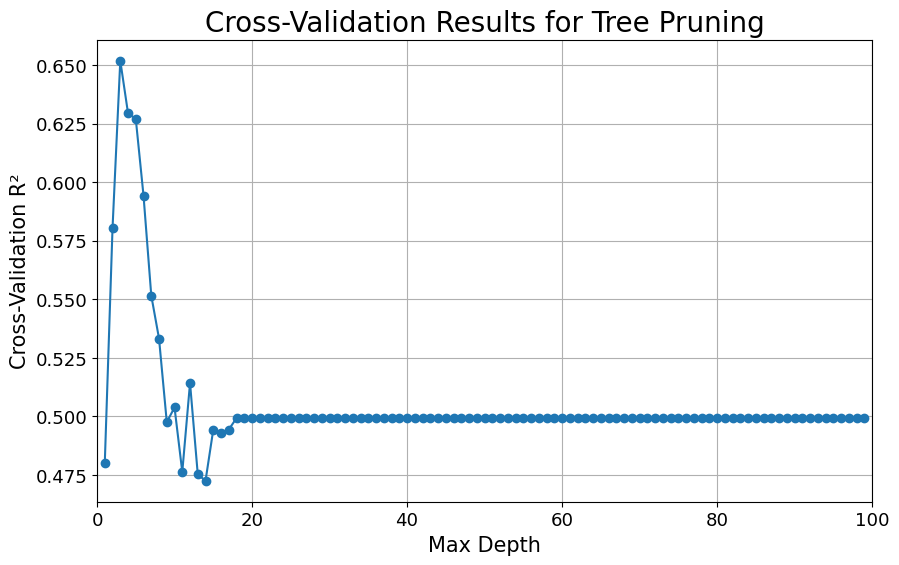

In [199]:
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, cv_scores, 'o-')
plt.xlabel('Max Depth', fontsize=15)
plt.ylabel('Cross-Validation R²', fontsize=15)
plt.title('Cross-Validation Results for Tree Pruning', fontsize=20)
plt.grid(True)
plt.xlim(0, 100)
plt.xticks(fontsize=13) 
plt.yticks(fontsize=13) 
plt.show()


The graph shows the effect of the decision tree depth on performance, using cross-validation and the R² score.  
The results show an initial increase in R² followed by a decrease, indicating the optimization between underfitting and overfitting.  
The optimal depth seems to be 3, as this is where R² is maximum.


In [200]:
best_depth = max_depth_values[np.argmax(cv_scores)]
print(f"Best depth from cross-validation: {best_depth}")

Best depth from cross-validation: 3


The optimal depth of 3 is confirmed, so we proceed with pruning.


In [201]:
pruned_tree = DecisionTreeRegressor(max_depth=best_depth, random_state=2)
pruned_tree.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=3, random_state=2)

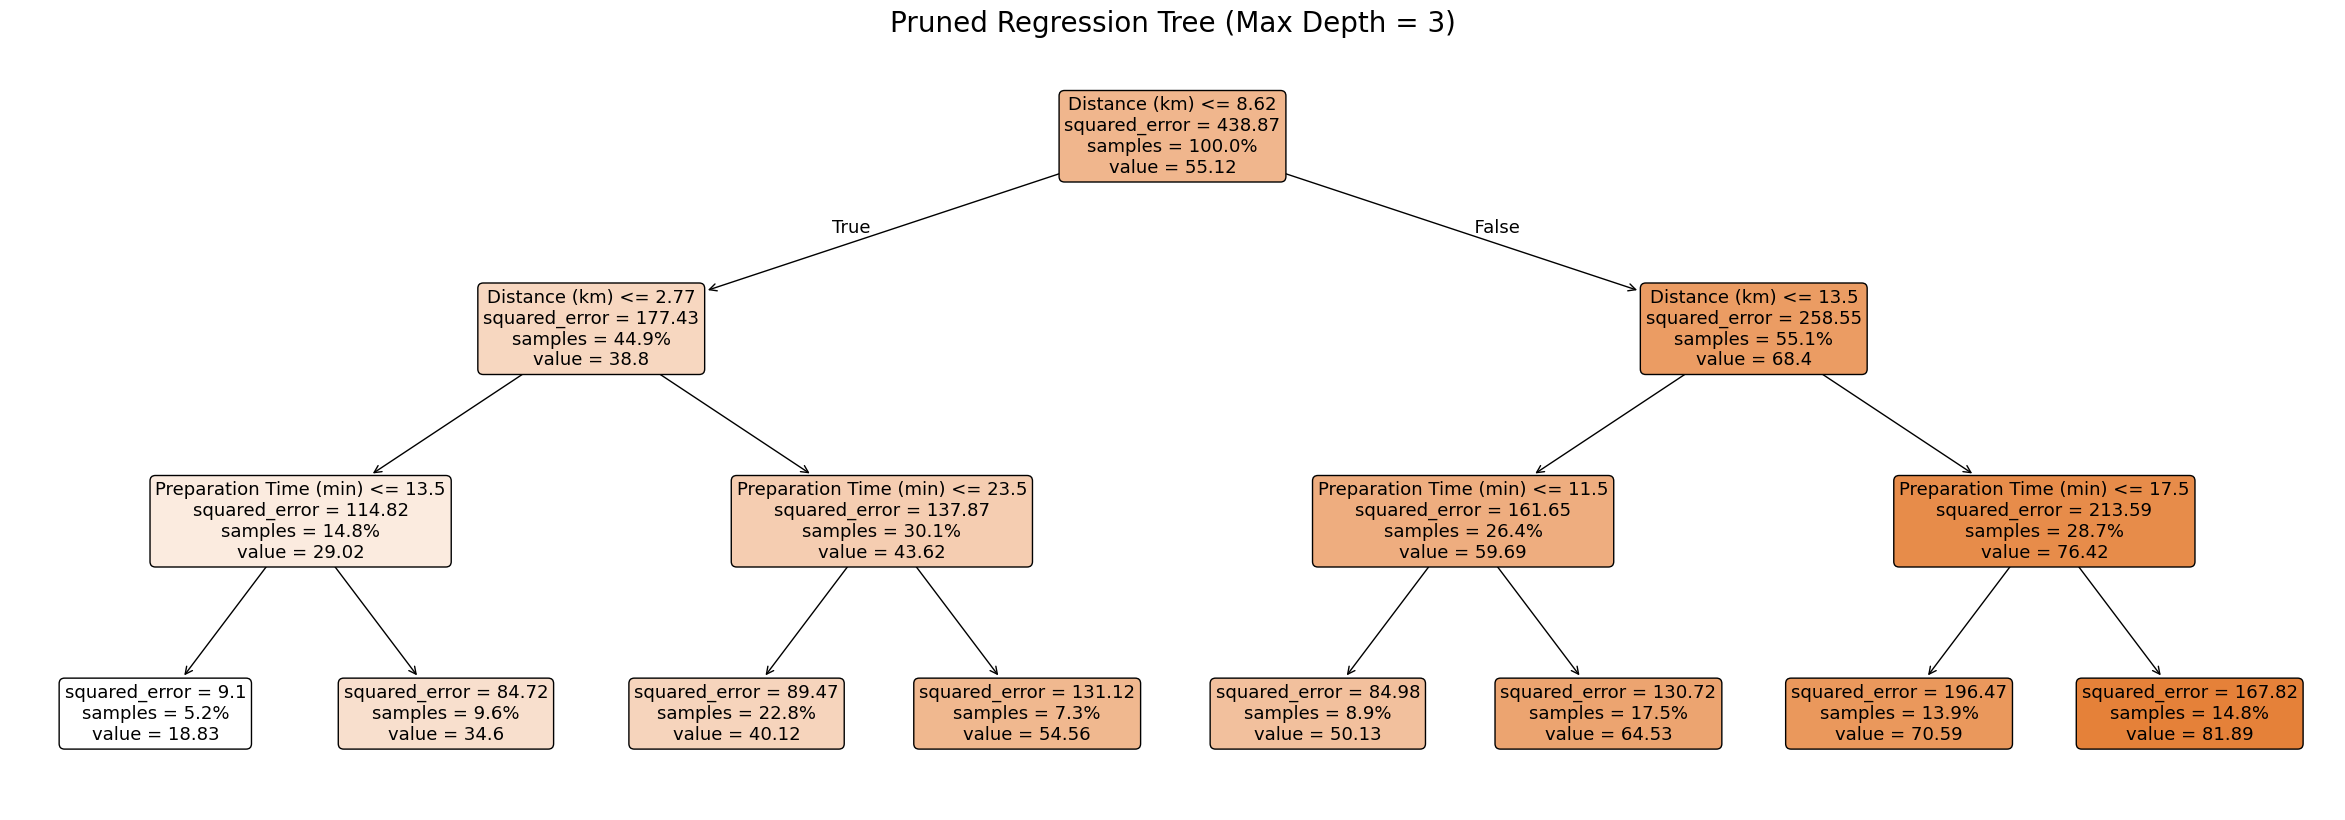

In [202]:
plt.figure(figsize=(30, 10))
plot_tree(pruned_tree, 
            feature_names=X.columns, 
            filled=True, 
            rounded=True,
            proportion=True,  
            fontsize=13,  
            precision=2)
plt.title(f'Pruned Regression Tree (Max Depth = {best_depth})', fontsize=20)
plt.show()


The pruned tree is much simpler and easier to explain.  
The only variables considered in the end are _Distance (km)_ and _Preparation Time (min)_.  
Dark orange indicate more extreme predicted values (higher or lower), while lighter or white colors indicate values close to the target mean.  
These do not represent categories, but rather continuous value gradations.


In [203]:
y_pred_pruned = pruned_tree.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_pruned)
mse = mean_squared_error(y_test, y_pred_pruned)
r2 = r2_score(y_test, y_pred_pruned)

print(f"MAE: {mae:.3f}")
print(f"R2: {r2:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {np.sqrt(mse):.3f}")

MAE: 9.438
R2: 0.608
MSE: 174.627
RMSE: 13.215


With pruning, the results have also improved.


- ## Bagging

We now try using ensemble methods for trees, starting with Bagging.  
Bagging builds multiple trees on different random subsets of the data and averages their predictions.  
This technique reduces variance and helps to improve model stability and accuracy.


In [204]:
categorical = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Courier_Experience']
Food[categorical] = Food[categorical].astype('category')

model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Time_of_Day',
    'Vehicle_Type',
    'Preparation_Time_min',
    'Courier_Experience'
])

X = model.fit_transform(Food)
y = Food['Delivery_Time_min']

X.columns = [variables.get(col, col) for col in X.columns]
for i, col in enumerate(X.columns):
    if '[' in col and ']' in col:
        base_col = col.split('[')[0]
        if base_col in variables:
            X.columns.values[i] = col.replace(base_col, variables[base_col])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=1
)

For Bagging, we use a Random Forest model with max features set equal to the total number of features.  
This ensures that each tree is built using all available variables, maintaining the standard Bagging approach where randomness comes only from the data sampling, not from feature selection.


In [205]:
bagg_model = RandomForestRegressor(
    n_estimators=500, 
    max_features=X.shape[1], 
    random_state=1,
    bootstrap=True  
)
bagg_model.fit(X_train, y_train)

RandomForestRegressor(max_features=16, n_estimators=500, random_state=1)

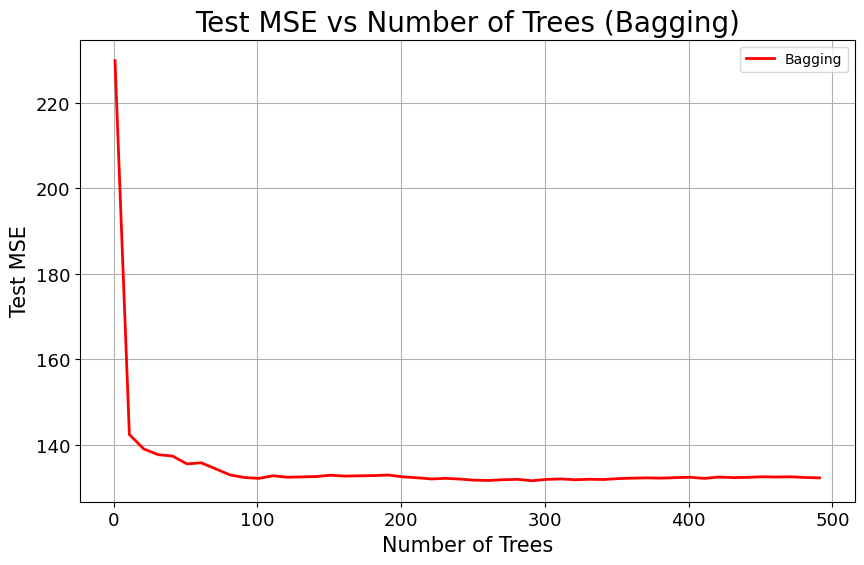

In [206]:
error_rate = []
X_test_array = X_test.to_numpy()

for i in range(1, 501, 10):
    y_pred_bagg = np.mean([t.predict(X_test_array) for t in bagg_model.estimators_[:i]], axis=0)
    error_rate.append(mean_squared_error(y_test, y_pred_bagg))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 501, 10), error_rate, 'r-', lw=2, label='Bagging')
plt.xlabel('Number of Trees', fontsize=15)
plt.ylabel('Test MSE', fontsize=15)
plt.title('Test MSE vs Number of Trees (Bagging)', fontsize=20)
plt.xticks(fontsize=13) 
plt.yticks(fontsize=13) 
plt.legend()
plt.grid(True)
plt.show()


In this graph, we see that as the number of trees increases, the MSE decreases.  
In particular, it stabilizes from around 100 trees onward.


In [207]:
y_pred_bagg = bagg_model.predict(X_test)
mse_bagg = mean_squared_error(y_test, y_pred_bagg)
print(f"Bagging MSE: {mse_bagg:.3f}")
print(f"Bagging RMSE: {np.sqrt(mse_bagg):.3f}")

Bagging MSE: 132.252
Bagging RMSE: 11.500


The residual analysis shows better results compared to previous tree-based models.


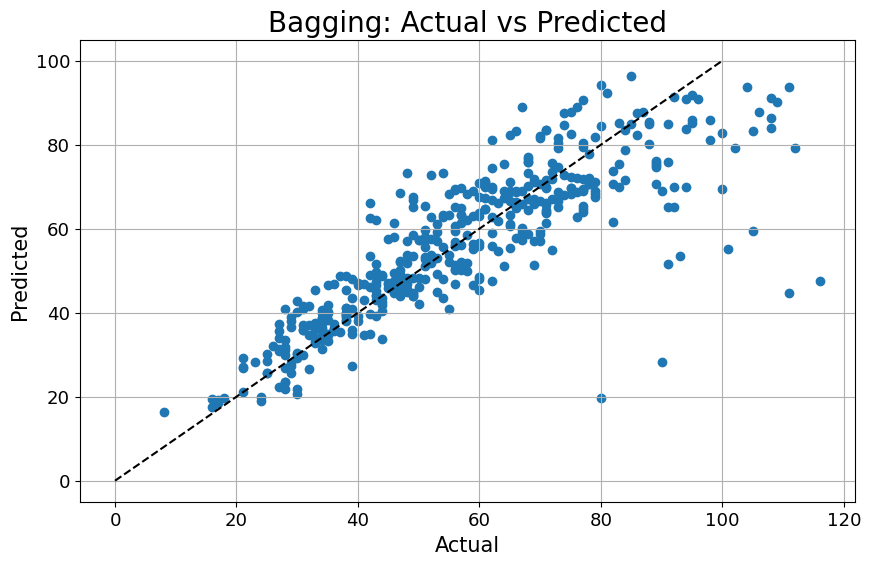

In [208]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_bagg)
plt.plot([0, 100], [0, 100], 'k--')
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predicted', fontsize=15)
plt.title('Bagging: Actual vs Predicted', fontsize=20)
plt.xticks(fontsize=13) 
plt.yticks(fontsize=13) 
plt.grid(True)
plt.show()

If the points lie on the bisector, the model is working well.  
The model estimated with Bagging is accurate.  
It performs better than a single tree but is still worse than linear models.  
Some outliers are present.


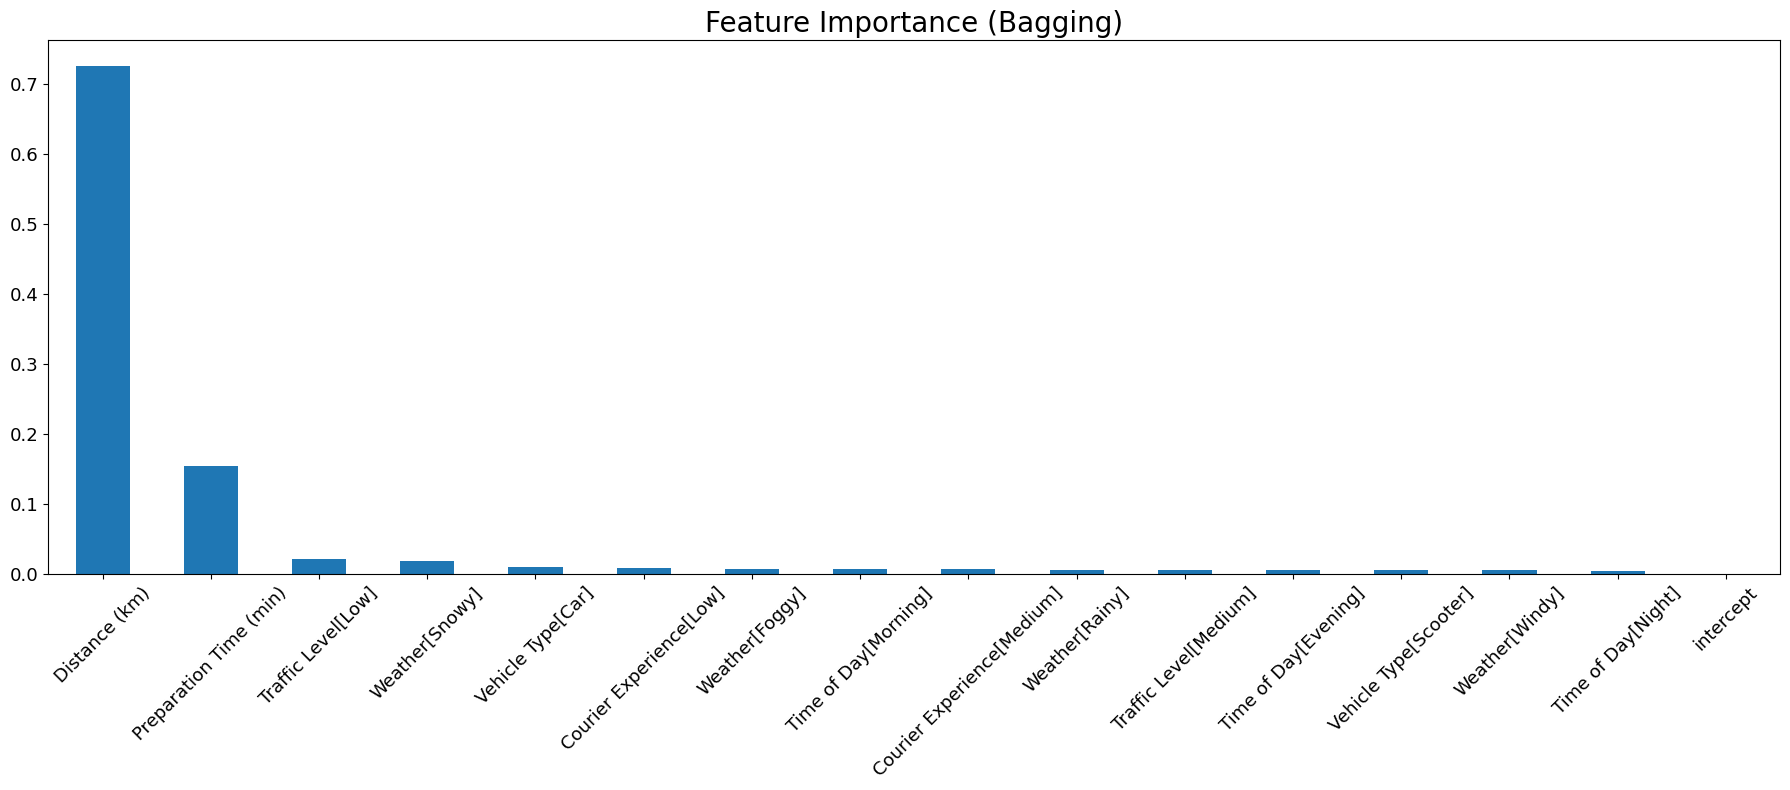

In [209]:
importance_bagg = pd.Series(bagg_model.feature_importances_, index=X.columns)
importance_bagg.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(18, 8))
importance_bagg.plot(kind='bar')
plt.title('Feature Importance (Bagging)', fontsize=20)
plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()


In this other plot, we see that the variable _Distance (km)_ dominates, followed by _Preparation Time (min)_, although with less than half the importance of the first.  
These results were expected considering the node values of the pruned tree built earlier.


- ## Random forest

Using Random Forest, which is an extension of Bagging, we introduce an additional layer of randomness by selecting a random subset of features at each split, rather than considering all features.  
This helps to reduce correlation between trees, improving the model's generalization and reducing overfitting compared to Bagging, where all features are used in each tree split.


In [210]:
forest_model = RandomForestRegressor(
    n_estimators=100, 
    max_features='sqrt',  
    random_state=1
)
forest_model.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', random_state=1)

In [211]:
error_rate_rf = []
X_test_array = X_test.to_numpy() 

for i in range(1, 501, 10):
    y_pred_rf = np.mean([t.predict(X_test_array) for t in forest_model.estimators_[:i]], axis=0)
    error_rate_rf.append(mean_squared_error(y_test, y_pred_rf))


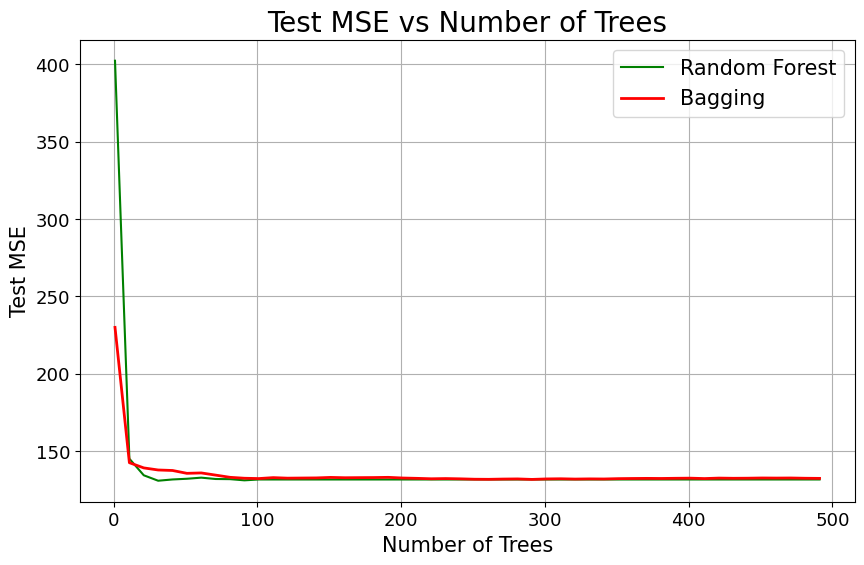

In [212]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 501, 10), error_rate_rf, 'g-', label='Random Forest')
plt.plot(range(1, 501, 10), error_rate, 'r-', lw=2, label='Bagging')
plt.xlabel('Number of Trees', fontsize=15)
plt.ylabel('Test MSE', fontsize=15)
plt.title('Test MSE vs Number of Trees', fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.grid(True)
plt.show()


In our case, as seen from the plot, Random Forest performs slightely better than Bagging.  
This could be due to Random Forest's random feature selection, which slightly reduces the influence of numerical variables while slightly improving the performance of categorical variables, leading to a better balance between them compared to Bagging.


In [213]:
y_pred_rf = forest_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest MSE: {mse_rf:.3f}")
print(f"Random Forest RMSE: {np.sqrt(mse_rf):.3f}")

Random Forest MSE: 131.571
Random Forest RMSE: 11.470


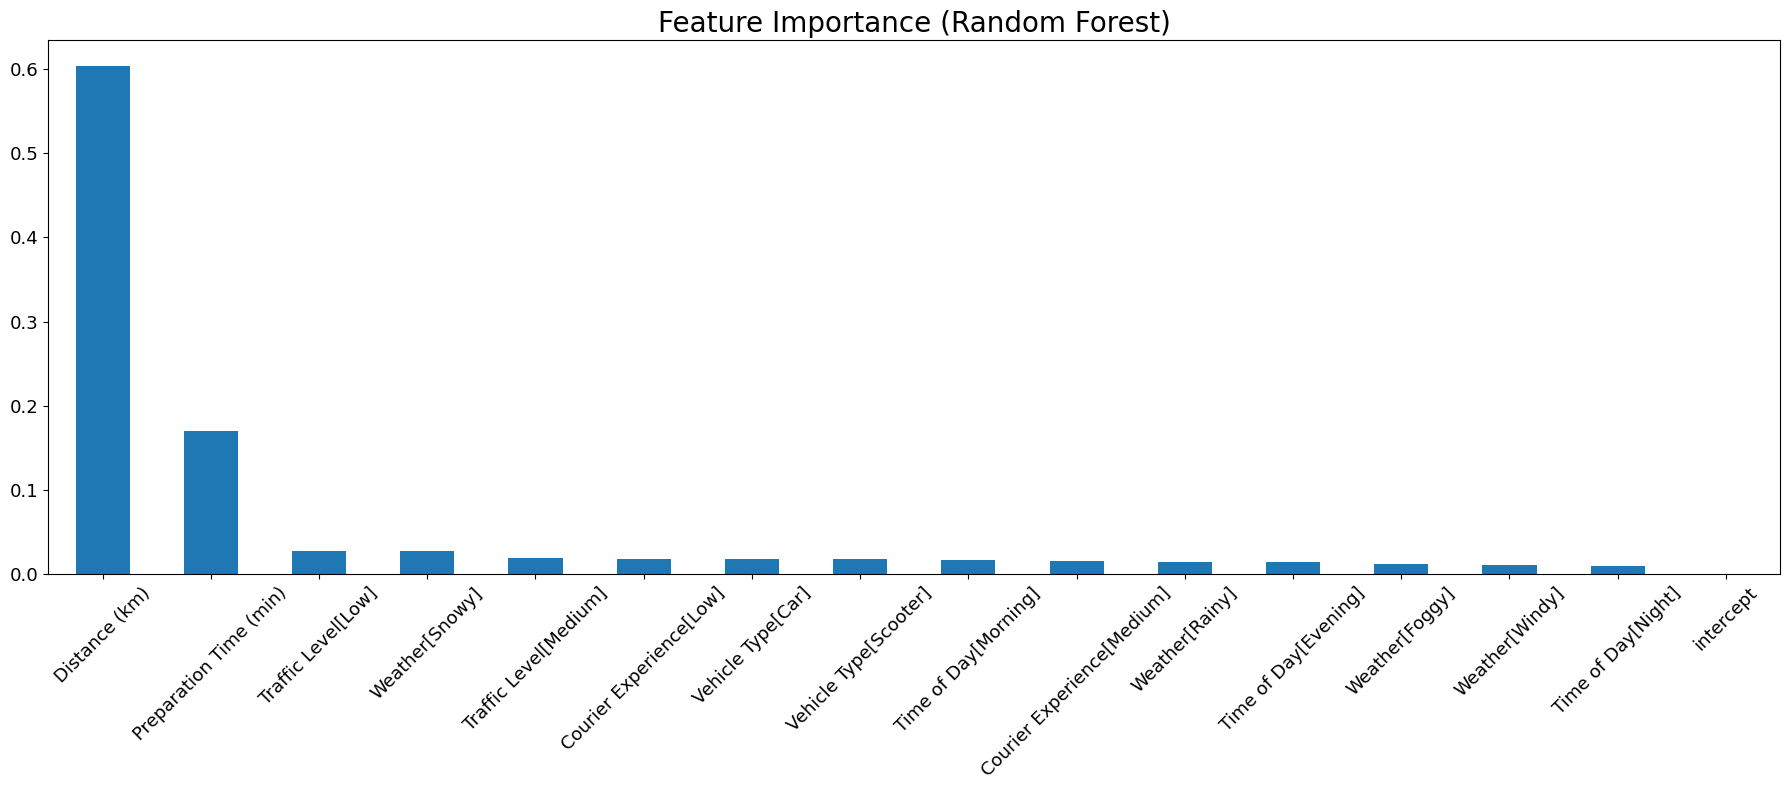

In [214]:
importance_rf = pd.Series(forest_model.feature_importances_, index=X.columns)
importance_rf.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(18, 8))
importance_rf.plot(kind='bar')
plt.title('Feature Importance (Random Forest)', fontsize=20)
plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()


Our previous statement is confirmed by the graph.

- ## Boosting

As the last tree-based method, we use Boosting.  
Boosting is an ensemble technique that builds multiple trees sequentially, where each tree corrects the errors of the previous one.  

In [215]:
boost_model = GradientBoostingRegressor(
    n_estimators=5000,
    max_depth=4,
    learning_rate=0.001,
    loss='squared_error',  
    random_state=1
)
boost_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, max_depth=4, n_estimators=5000,
                          random_state=1)

In [216]:
y_pred_boost = boost_model.predict(X_test)
mse_boost = mean_squared_error(y_test, y_pred_boost)
print(f"Boosting MSE: {mse_boost:.3f}")
print(f"Boosting RMSE: {np.sqrt(mse_boost):.3f}")

methods = ['Bagging', 'Random Forest', 'Boosting']
mse_values = [mse_bagg, mse_rf, mse_boost]

Boosting MSE: 122.121
Boosting RMSE: 11.051


Based on the results, it appears that Boosting is the most effective tree-based method.  
However, it still underperforms compared to the initial linear regression models, which remain the most accurate for this dataset.  


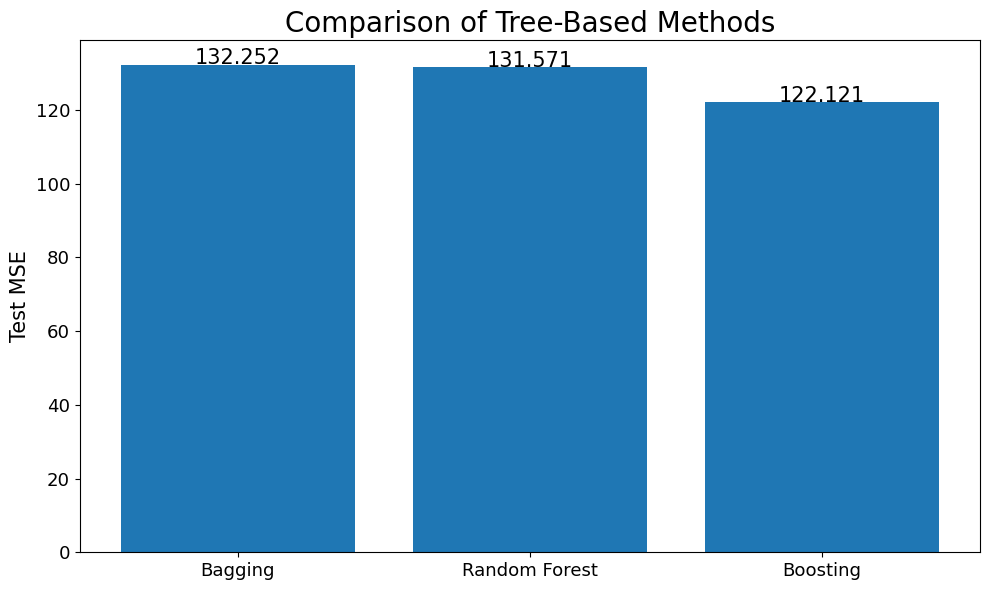

In [217]:
plt.figure(figsize=(10, 6))
plt.bar(methods, mse_values)
plt.ylabel('Test MSE', fontsize=15)
plt.title('Comparison of Tree-Based Methods', fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
for i, v in enumerate(mse_values):
    plt.text(i, v + 0.1, f"{v:.3f}", ha='center', fontsize=15)
plt.tight_layout()
plt.show()

The graph compares the performance of three ensemble methods: Bagging, Random Forest, and Boosting.
As shown, Boosting achieving slightly better results.


---

In [44]:
y = Food['Delivery_Time_min']
y_transformed = np.sqrt(y)

# Conversione variabili categoriche
categorical = ['Weather', 'Traffic_Level', 'Courier_Experience']
Food[categorical] = Food[categorical].astype('category')

# Codifica delle variabili tramite MS
model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Preparation_Time_min',
    'Courier_Experience',
])
X = model.fit_transform(Food).values  # array numpy

# Cross Validation 10-fold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

r2_scores = []
mse_scores = []
rmse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_transformed.iloc[train_index], y.iloc[test_index]  # attenzione: test ancora non trasformato

    # Fit modello sui dati trasformati
    mod = sm.OLS(y_train, X_train)
    res = mod.fit()
    y_pred_sqrt = res.predict(X_test)

    # Inversione della trasformazione sqrt
    y_pred = np.square(y_pred_sqrt)

    # Calcolo metriche sul test (valori originali)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    r2_scores.append(r2)
    mse_scores.append(mse)
    rmse_scores.append(rmse)

# Risultati medi delle metriche
print("\n10-Fold Cross Validation Results (sqrt model on test set):")
print(f"Mean R²:   {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")
print(f"Mean MSE:  {np.mean(mse_scores):.3f} ± {np.std(mse_scores):.3f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.3f} ± {np.std(rmse_scores):.3f}")



10-Fold Cross Validation Results (sqrt model on test set):
Mean R²:   0.780 ± 0.064
Mean MSE:  96.278 ± 30.236
Mean RMSE: 9.696 ± 1.504


In [47]:
from sklearn.base import BaseEstimator, RegressorMixin

class SqrtTargetModel(BaseEstimator, RegressorMixin):
    def __init__(self, base_model, transformer):
        self.base_model = base_model
        self.transformer = transformer  # MS pipeline
    
    def fit(self, X, y):
        # Trasformo y con sqrt
        y_transformed = np.sqrt(y)
        # Trasformo X con pipeline
        X_transformed = self.transformer.fit_transform(X)
        # Fit modello statsmodels
        self.model_ = self.base_model(y_transformed, X_transformed).fit()
        return self
    
    def predict(self, X):
        X_transformed = self.transformer.transform(X)
        y_pred_sqrt = self.model_.predict(X_transformed)
        # Inversione trasformazione sqrt
        return np.square(y_pred_sqrt)

# Inizializzo la pipeline e il modello wrapper
transformer = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Preparation_Time_min',
    'Courier_Experience'
])

base_model = sm.OLS

kf_model = SqrtTargetModel(base_model, transformer)

# Dati
X = Food.drop(columns=['Delivery_Time_min'])
y = Food['Delivery_Time_min']

# Cross-validation 10 fold
kf = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_validate(kf_model, X, y, cv=kf,
                            scoring=['r2', 'neg_mean_squared_error'],
                            return_train_score=False)

# Calcolo metriche medie su test
r2_mean = np.mean(cv_results['test_r2'])
mse_mean = -np.mean(cv_results['test_neg_mean_squared_error'])
rmse_mean = np.sqrt(mse_mean)

print(f"Mean R²: {r2_mean:.3f}")
print(f"Mean MSE: {mse_mean:.3f}")
print(f"Mean RMSE: {rmse_mean:.3f}")

Mean R²: 0.778
Mean MSE: 96.210
Mean RMSE: 9.809


In [48]:
from sklearn.base import BaseEstimator, RegressorMixin

class LinearTargetModel(BaseEstimator, RegressorMixin):
    def __init__(self, base_model, transformer):
        self.base_model = base_model
        self.transformer = transformer  # MS pipeline
    
    def fit(self, X, y):
        X_transformed = self.transformer.fit_transform(X)
        self.model_ = self.base_model(y, X_transformed).fit()
        return self
    
    def predict(self, X):
        X_transformed = self.transformer.transform(X)
        return self.model_.predict(X_transformed)

# Inizializzo la pipeline e il modello wrapper
transformer = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Preparation_Time_min',
    'Courier_Experience'
])

base_model = sm.OLS

kf_model = LinearTargetModel(base_model, transformer)

# Dati
X = Food.drop(columns=['Delivery_Time_min'])
y = Food['Delivery_Time_min']

# Cross-validation 10 fold
kf = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_validate(kf_model, X, y, cv=kf,
                            scoring=['r2', 'neg_mean_squared_error'],
                            return_train_score=False)

# Calcolo metriche medie su test
r2_mean = np.mean(cv_results['test_r2'])
mse_mean = -np.mean(cv_results['test_neg_mean_squared_error'])
rmse_mean = np.sqrt(mse_mean)

print(f"Mean R²: {r2_mean:.3f}")
print(f"Mean MSE: {mse_mean:.3f}")
print(f"Mean RMSE: {rmse_mean:.3f}")


Mean R²: 0.794
Mean MSE: 89.613
Mean RMSE: 9.466
